## Import necessary libraries

In [33]:
import numpy as np
import idx2numpy
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the dataset

In [34]:
# Load the MNIST dataset
train_images = idx2numpy.convert_from_file('train-images.idx3-ubyte')
train_labels = idx2numpy.convert_from_file('train-labels.idx1-ubyte')
test_images = idx2numpy.convert_from_file('t10k-images.idx3-ubyte')
test_labels = idx2numpy.convert_from_file('t10k-labels.idx1-ubyte')

# Normalize the image data

In [35]:
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape data for ANN and CNN

In [36]:
train_images_ann = train_images.reshape(train_images.shape[0], -1)
test_images_ann = test_images.reshape(test_images.shape[0], -1)

train_images_cnn = train_images.reshape(train_images.shape[0], 1, 28, 28)
test_images_cnn = test_images.reshape(test_images.shape[0], 1, 28, 28)

# Split data

In [37]:
train_data_ann, val_data_ann, train_targets, val_targets = train_test_split(
    train_images_ann, train_labels, test_size=10000, stratify=train_labels, random_state=42
)
train_data_cnn, val_data_cnn = train_test_split(
    train_images_cnn, test_size=10000, stratify=train_labels, random_state=42
)

# Verify class distributions

In [38]:
unique, counts = np.unique(train_targets, return_counts=True)
print("Training set class distribution:", dict(zip(unique, counts)))
unique, counts = np.unique(val_targets, return_counts=True)
print("Validation set class distribution:", dict(zip(unique, counts)))
unique, counts = np.unique(test_labels, return_counts=True)
print("Test set class distribution:", dict(zip(unique, counts)))
print(f"Training set ANN: {len(train_data_ann)} samples")
print(f"Training set CNN: {len(train_data_cnn)} samples")
print(f"Validation set ANN: {len(val_data_ann)} samples")
print(f"Validation set CNN: {len(val_data_cnn)} samples")
print(f"Test set: {len(test_images)} samples")

Training set class distribution: {0: 4936, 1: 5618, 2: 4965, 3: 5109, 4: 4868, 5: 4518, 6: 4932, 7: 5221, 8: 4876, 9: 4957}
Validation set class distribution: {0: 987, 1: 1124, 2: 993, 3: 1022, 4: 974, 5: 903, 6: 986, 7: 1044, 8: 975, 9: 992}
Test set class distribution: {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}
Training set ANN: 50000 samples
Training set CNN: 50000 samples
Validation set ANN: 10000 samples
Validation set CNN: 10000 samples
Test set: 10000 samples


# Create datasets for ANN and CNN

In [39]:
train_dataset_ann = TensorDataset(torch.tensor(train_data_ann, dtype=torch.float32).to(device),
                                   torch.tensor(train_targets, dtype=torch.long).to(device))
val_dataset_ann = TensorDataset(torch.tensor(val_data_ann, dtype=torch.float32).to(device),
                                 torch.tensor(val_targets, dtype=torch.long).to(device))
test_dataset_ann = TensorDataset(torch.tensor(test_images_ann, dtype=torch.float32).to(device),
                                  torch.tensor(test_labels, dtype=torch.long).to(device))

train_dataset_cnn = TensorDataset(torch.tensor(train_data_cnn, dtype=torch.float32).to(device),
                                   torch.tensor(train_targets, dtype=torch.long).to(device))
val_dataset_cnn = TensorDataset(torch.tensor(val_data_cnn, dtype=torch.float32).to(device),
                                 torch.tensor(val_targets, dtype=torch.long).to(device))
test_dataset_cnn = TensorDataset(torch.tensor(test_images_cnn, dtype=torch.float32).to(device),
                                  torch.tensor(test_labels, dtype=torch.long).to(device))

# Defining ANN

In [40]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_config):
        super(NeuralNetwork, self).__init__()
        self.layers = []
        input_size = 28 * 28
        for units in layer_config:
            self.layers.append(nn.Linear(input_size, units))
            self.layers.append(nn.ReLU())
            input_size = units
        self.layers.append(nn.Linear(input_size, 10))
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

# Defining CNN

In [41]:
class CNNModel(nn.Module):
    def __init__(self, layer_config, dropout_rate=0.25):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.ModuleList()
        input_channels = 1
        output_channels = 32
        # Create convolutional layers based on the provided layer_config
        for units in layer_config:
            self.conv_layers.append(nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1))
            input_channels = output_channels
            output_channels = units
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        dummy_input = torch.zeros((1, 1, 28, 28))
        x = dummy_input
        for conv_layer in self.conv_layers:
            x = self.pool(F.relu(conv_layer(x)))
        self.flatten_size = x.numel()
        self.fc_layers = nn.ModuleList()
        in_features = self.flatten_size
        for units in layer_config:
            self.fc_layers.append(nn.Linear(in_features, units))
            in_features = units
        self.fc_layers.append(nn.Linear(in_features, 10))
        self.dropout = nn.Dropout(dropout_rate)
    def forward(self, x):
        for conv_layer in self.conv_layers:
            x = self.pool(F.relu(conv_layer(x)))
        x = x.view(x.size(0), -1)
        for fc_layer in self.fc_layers[:-1]:
            x = F.relu(fc_layer(x))
            x = self.dropout(x)
        x = self.fc_layers[-1](x)
        return x

# Function to evaluate models

In [42]:
def evaluate_model(model, criterion, loader):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()
            _, preds = torch.max(output, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return val_loss / len(loader), accuracy

# Function to train models

In [43]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(output, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)
        val_loss, val_accuracy = evaluate_model(model, criterion, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(
            f"Epoch {epoch + 1} - Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Function to plot metrics

In [44]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, title):
    plt.ion()
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show(block=False)
    plt.pause(1)

# Function to Tune Hyperparameters

In [45]:
def tune_hyperparameter(hyperparameter_values, model_type, tune_param, best_hyperparams, criterion, epochs=15):
    for value in hyperparameter_values:
        print(f"\nTesting {tune_param}: {value} for {model_type}")

        if model_type == "ANN":
            model = NeuralNetwork(best_hyperparams[model_type]['architecture'] if tune_param != "architecture" else value)
            train_loader = DataLoader(train_dataset_ann, batch_size=best_hyperparams[model_type]['batch_size'] if tune_param != "batch_size" else value, shuffle=True)
            val_loader = DataLoader(val_dataset_ann, batch_size=best_hyperparams[model_type]['batch_size'] if tune_param != "batch_size" else value, shuffle=False)
        elif model_type == "CNN":
            model = CNNModel(best_hyperparams[model_type]['architecture'] if tune_param != "architecture" else value)
            train_loader = DataLoader(train_dataset_cnn, batch_size=best_hyperparams[model_type]['batch_size'] if tune_param != "batch_size" else value, shuffle=True)
            val_loader = DataLoader(val_dataset_cnn, batch_size=best_hyperparams[model_type]['batch_size'] if tune_param != "batch_size" else value, shuffle=False)
        else:
            raise ValueError("Invalid model_type. Choose 'ANN' or 'CNN'.")
        model = model.to(device)
        optimizer = optim.SGD(model.parameters(), lr=best_hyperparams[model_type]['lr'] if tune_param != "lr" else value)
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, criterion, optimizer, train_loader, val_loader, epochs
        )

        plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, f"{model_type} - {tune_param} {value}")

        if val_losses[-1] < best_hyperparams[model_type]["val_loss"]:
            best_hyperparams[model_type].update({tune_param: value, "val_loss": val_losses[-1]})

    print(f"Best {model_type} {tune_param}: {best_hyperparams[model_type][tune_param]}")
    return best_hyperparams

# Defining Set of values for hyperparameters

In [ ]:
best_hyperparams = {
    "ANN": {"lr": None, "batch_size": 64, "architecture": [256, 128], "val_loss": float("inf")},
    "CNN": {"lr": None, "batch_size": 64, "architecture": [256, 128], "val_loss": float("inf")},
}
learning_rates = [0.001, 0.01, 0.05, 0.1]
batch_sizes = [32, 64, 128, 256]
layer_configs = [
    [64, 32],
    [128, 64],
    [256, 128],
    [512, 256],

    [256],
    [256, 128],
    [256, 128, 64],
    [256, 128, 64, 32]
]
criterion = nn.CrossEntropyLoss()

# Tuning Hyperparameters for ANN & CNN 


Testing lr: 0.001 for ANN
Epoch 1 - Training Loss: 2.2927, Validation Loss: 2.2786, Validation Accuracy: 0.1839
Epoch 2 - Training Loss: 2.2621, Validation Loss: 2.2438, Validation Accuracy: 0.3184
Epoch 3 - Training Loss: 2.2194, Validation Loss: 2.1916, Validation Accuracy: 0.5291
Epoch 4 - Training Loss: 2.1533, Validation Loss: 2.1096, Validation Accuracy: 0.6002
Epoch 5 - Training Loss: 2.0498, Validation Loss: 1.9823, Validation Accuracy: 0.6297
Epoch 6 - Training Loss: 1.8943, Validation Loss: 1.7981, Validation Accuracy: 0.6646
Epoch 7 - Training Loss: 1.6822, Validation Loss: 1.5636, Validation Accuracy: 0.6959
Epoch 8 - Training Loss: 1.4371, Validation Loss: 1.3185, Validation Accuracy: 0.7315
Epoch 9 - Training Loss: 1.2061, Validation Loss: 1.1087, Validation Accuracy: 0.7637
Epoch 10 - Training Loss: 1.0207, Validation Loss: 0.9486, Validation Accuracy: 0.7914
Epoch 11 - Training Loss: 0.8829, Validation Loss: 0.8313, Validation Accuracy: 0.8064
Epoch 12 - Training Loss:

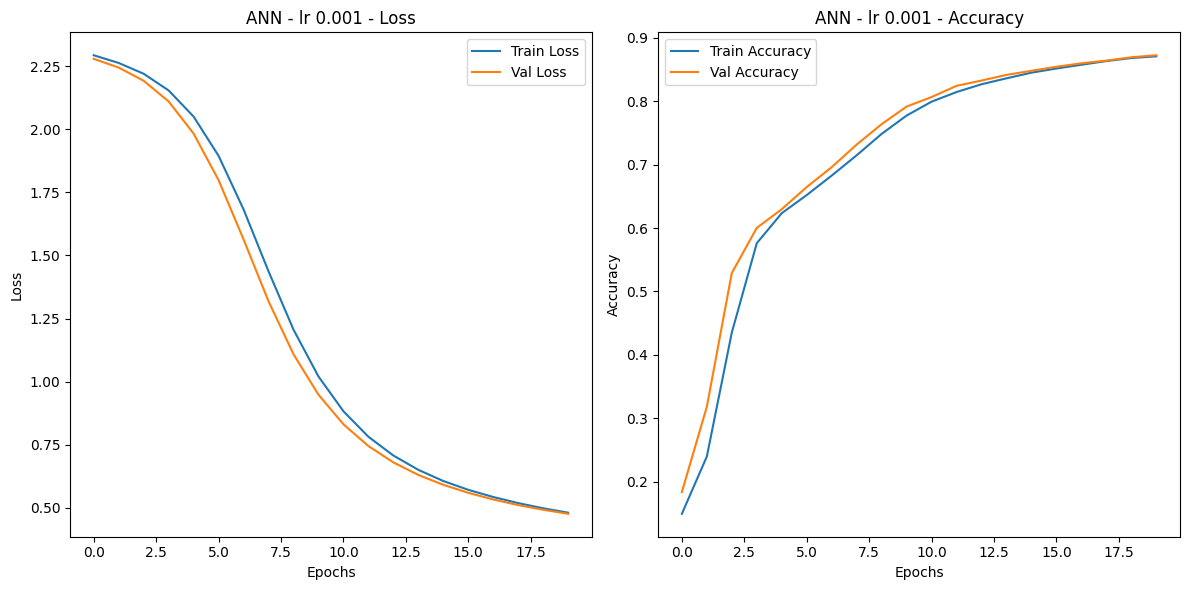


Testing lr: 0.01 for ANN
Epoch 1 - Training Loss: 1.8165, Validation Loss: 0.9537, Validation Accuracy: 0.7704
Epoch 2 - Training Loss: 0.6436, Validation Loss: 0.4938, Validation Accuracy: 0.8654
Epoch 3 - Training Loss: 0.4293, Validation Loss: 0.3923, Validation Accuracy: 0.8914
Epoch 4 - Training Loss: 0.3651, Validation Loss: 0.3490, Validation Accuracy: 0.9028
Epoch 5 - Training Loss: 0.3311, Validation Loss: 0.3230, Validation Accuracy: 0.9085
Epoch 6 - Training Loss: 0.3074, Validation Loss: 0.3042, Validation Accuracy: 0.9131
Epoch 7 - Training Loss: 0.2879, Validation Loss: 0.2876, Validation Accuracy: 0.9177
Epoch 8 - Training Loss: 0.2712, Validation Loss: 0.2756, Validation Accuracy: 0.9199
Epoch 9 - Training Loss: 0.2561, Validation Loss: 0.2587, Validation Accuracy: 0.9281
Epoch 10 - Training Loss: 0.2420, Validation Loss: 0.2487, Validation Accuracy: 0.9272
Epoch 11 - Training Loss: 0.2291, Validation Loss: 0.2382, Validation Accuracy: 0.9329
Epoch 12 - Training Loss: 

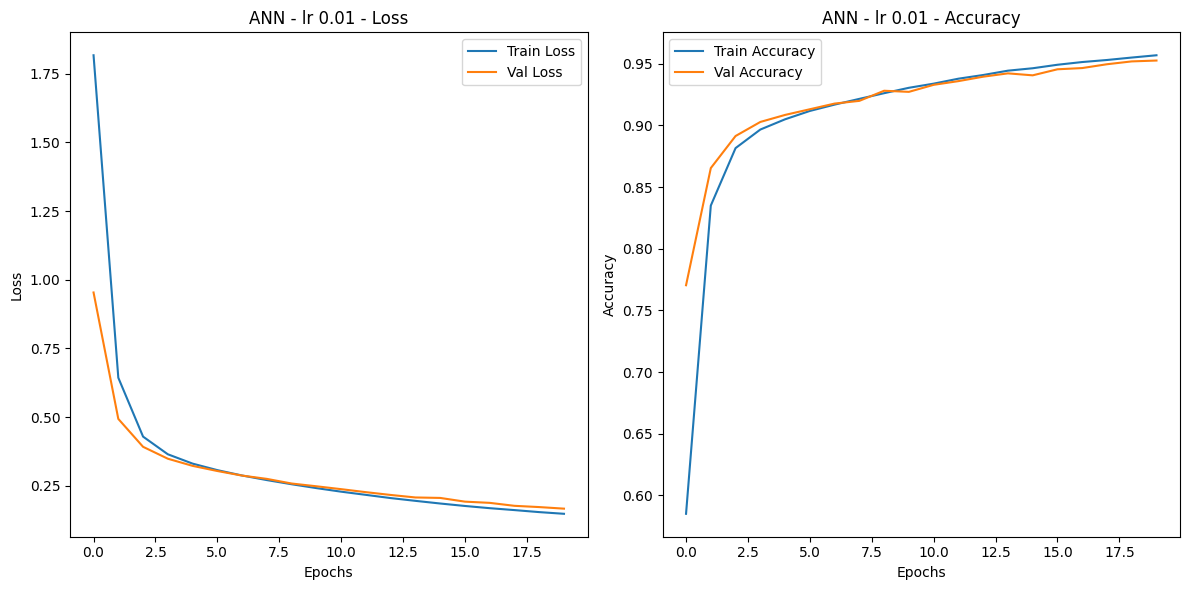


Testing lr: 0.05 for ANN
Epoch 1 - Training Loss: 0.7428, Validation Loss: 0.3409, Validation Accuracy: 0.8999
Epoch 2 - Training Loss: 0.2840, Validation Loss: 0.2498, Validation Accuracy: 0.9269
Epoch 3 - Training Loss: 0.2137, Validation Loss: 0.3223, Validation Accuracy: 0.9036
Epoch 4 - Training Loss: 0.1696, Validation Loss: 0.1753, Validation Accuracy: 0.9496
Epoch 5 - Training Loss: 0.1394, Validation Loss: 0.1497, Validation Accuracy: 0.9567
Epoch 6 - Training Loss: 0.1179, Validation Loss: 0.1312, Validation Accuracy: 0.9623
Epoch 7 - Training Loss: 0.1019, Validation Loss: 0.1325, Validation Accuracy: 0.9610
Epoch 8 - Training Loss: 0.0888, Validation Loss: 0.1154, Validation Accuracy: 0.9654
Epoch 9 - Training Loss: 0.0780, Validation Loss: 0.1093, Validation Accuracy: 0.9676
Epoch 10 - Training Loss: 0.0689, Validation Loss: 0.1001, Validation Accuracy: 0.9695
Epoch 11 - Training Loss: 0.0610, Validation Loss: 0.1586, Validation Accuracy: 0.9535
Epoch 12 - Training Loss: 

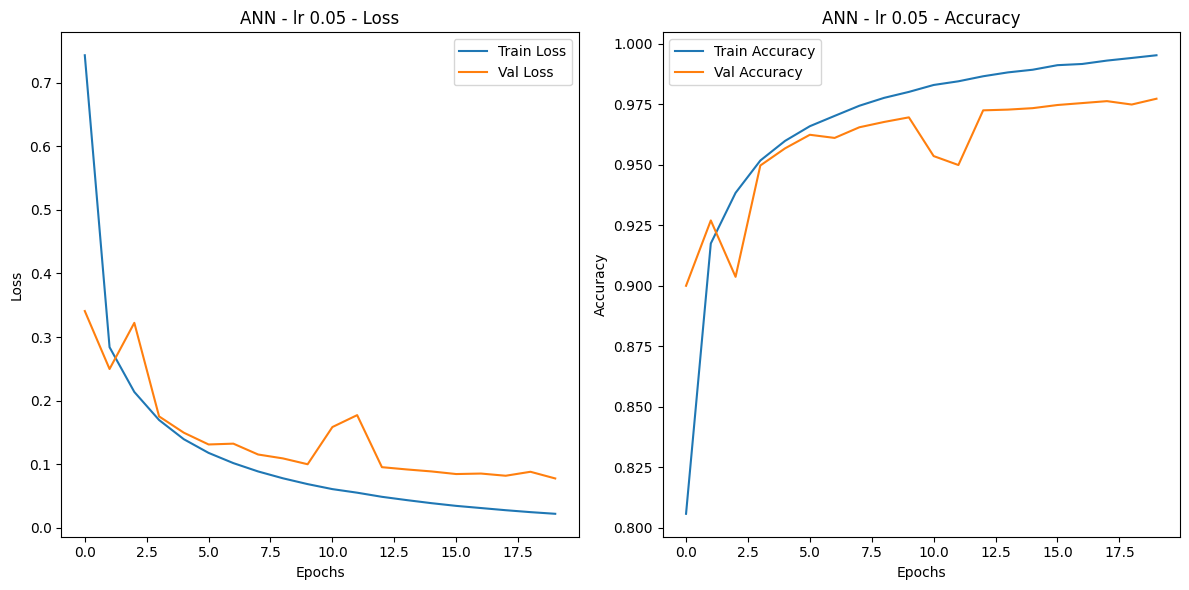


Testing lr: 0.1 for ANN
Epoch 1 - Training Loss: 0.5255, Validation Loss: 0.3474, Validation Accuracy: 0.8971
Epoch 2 - Training Loss: 0.2031, Validation Loss: 0.2081, Validation Accuracy: 0.9397
Epoch 3 - Training Loss: 0.1396, Validation Loss: 0.1749, Validation Accuracy: 0.9484
Epoch 4 - Training Loss: 0.1047, Validation Loss: 0.1123, Validation Accuracy: 0.9657
Epoch 5 - Training Loss: 0.0830, Validation Loss: 0.1687, Validation Accuracy: 0.9461
Epoch 6 - Training Loss: 0.0685, Validation Loss: 0.0941, Validation Accuracy: 0.9725
Epoch 7 - Training Loss: 0.0550, Validation Loss: 0.3614, Validation Accuracy: 0.8914
Epoch 8 - Training Loss: 0.0464, Validation Loss: 0.0860, Validation Accuracy: 0.9748
Epoch 9 - Training Loss: 0.0391, Validation Loss: 0.1130, Validation Accuracy: 0.9655
Epoch 10 - Training Loss: 0.0317, Validation Loss: 0.0774, Validation Accuracy: 0.9773
Epoch 11 - Training Loss: 0.0258, Validation Loss: 0.0796, Validation Accuracy: 0.9771
Epoch 12 - Training Loss: 0

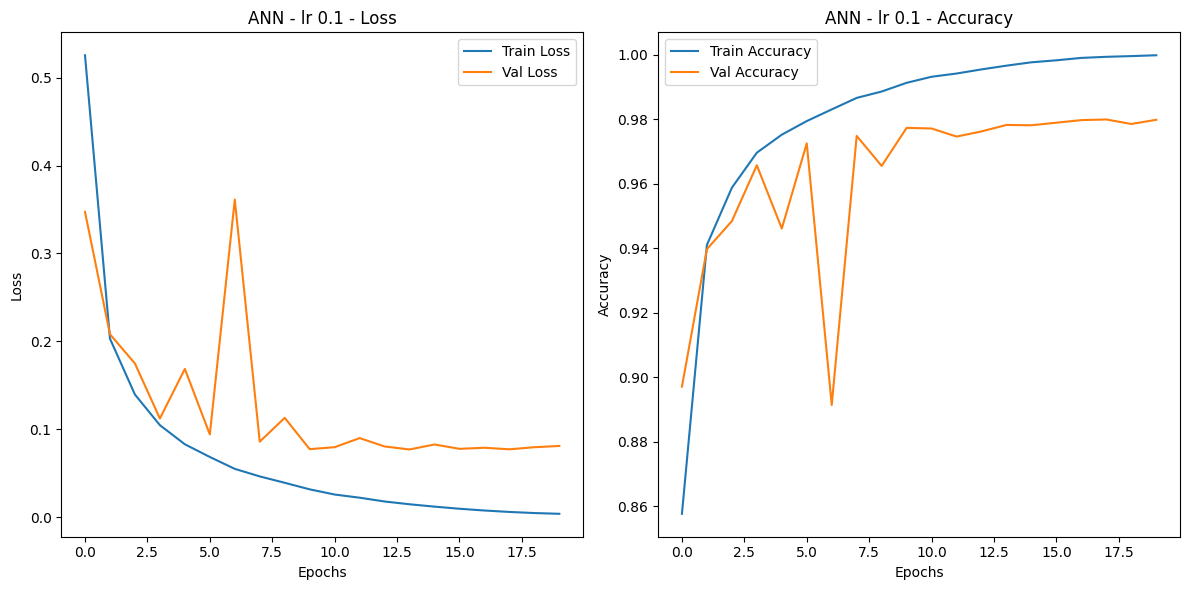

Best ANN lr: 0.05

Testing lr: 0.001 for CNN
Epoch 1 - Training Loss: 2.2906, Validation Loss: 2.2744, Validation Accuracy: 0.3351
Epoch 2 - Training Loss: 2.2586, Validation Loss: 2.2328, Validation Accuracy: 0.3839
Epoch 3 - Training Loss: 2.2037, Validation Loss: 2.1500, Validation Accuracy: 0.4698
Epoch 4 - Training Loss: 2.0782, Validation Loss: 1.9378, Validation Accuracy: 0.5365
Epoch 5 - Training Loss: 1.7559, Validation Loss: 1.4349, Validation Accuracy: 0.6832
Epoch 6 - Training Loss: 1.2628, Validation Loss: 0.9329, Validation Accuracy: 0.7634
Epoch 7 - Training Loss: 0.9173, Validation Loss: 0.6796, Validation Accuracy: 0.8114
Epoch 8 - Training Loss: 0.7285, Validation Loss: 0.5483, Validation Accuracy: 0.8510
Epoch 9 - Training Loss: 0.6212, Validation Loss: 0.4700, Validation Accuracy: 0.8706
Epoch 10 - Training Loss: 0.5487, Validation Loss: 0.4197, Validation Accuracy: 0.8801


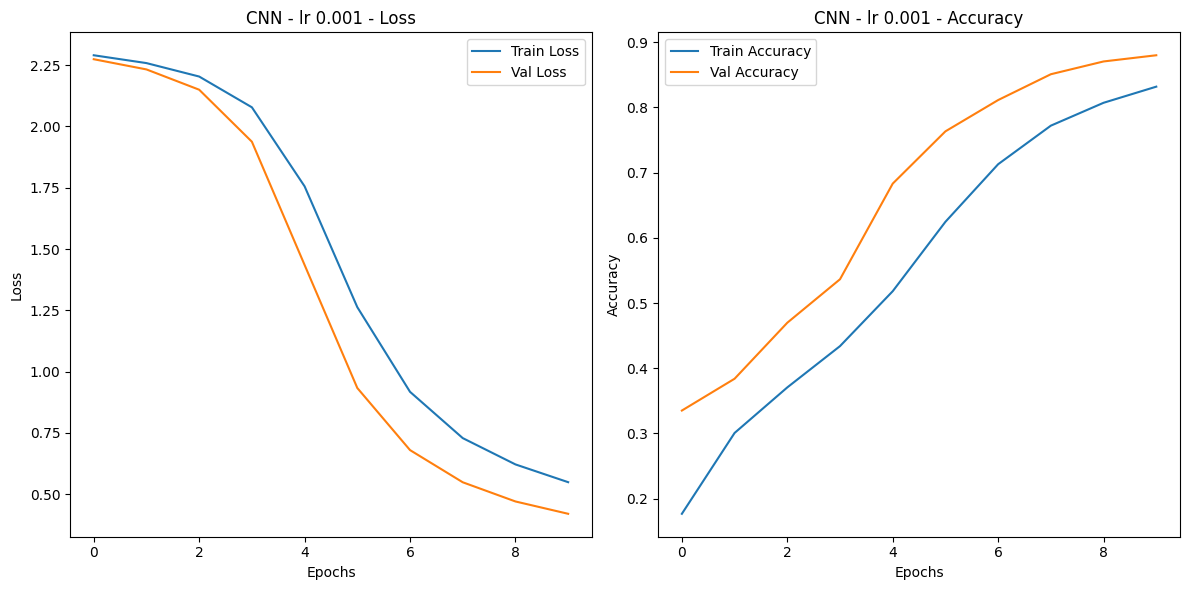


Testing lr: 0.01 for CNN
Epoch 1 - Training Loss: 1.4754, Validation Loss: 0.5519, Validation Accuracy: 0.8277
Epoch 2 - Training Loss: 0.4175, Validation Loss: 0.2676, Validation Accuracy: 0.9172
Epoch 3 - Training Loss: 0.2841, Validation Loss: 0.2413, Validation Accuracy: 0.9236
Epoch 4 - Training Loss: 0.2140, Validation Loss: 0.1440, Validation Accuracy: 0.9541
Epoch 5 - Training Loss: 0.1732, Validation Loss: 0.1262, Validation Accuracy: 0.9594
Epoch 6 - Training Loss: 0.1433, Validation Loss: 0.1109, Validation Accuracy: 0.9653
Epoch 7 - Training Loss: 0.1258, Validation Loss: 0.0887, Validation Accuracy: 0.9739
Epoch 8 - Training Loss: 0.1102, Validation Loss: 0.0854, Validation Accuracy: 0.9740
Epoch 9 - Training Loss: 0.1015, Validation Loss: 0.0749, Validation Accuracy: 0.9768
Epoch 10 - Training Loss: 0.0936, Validation Loss: 0.0775, Validation Accuracy: 0.9769


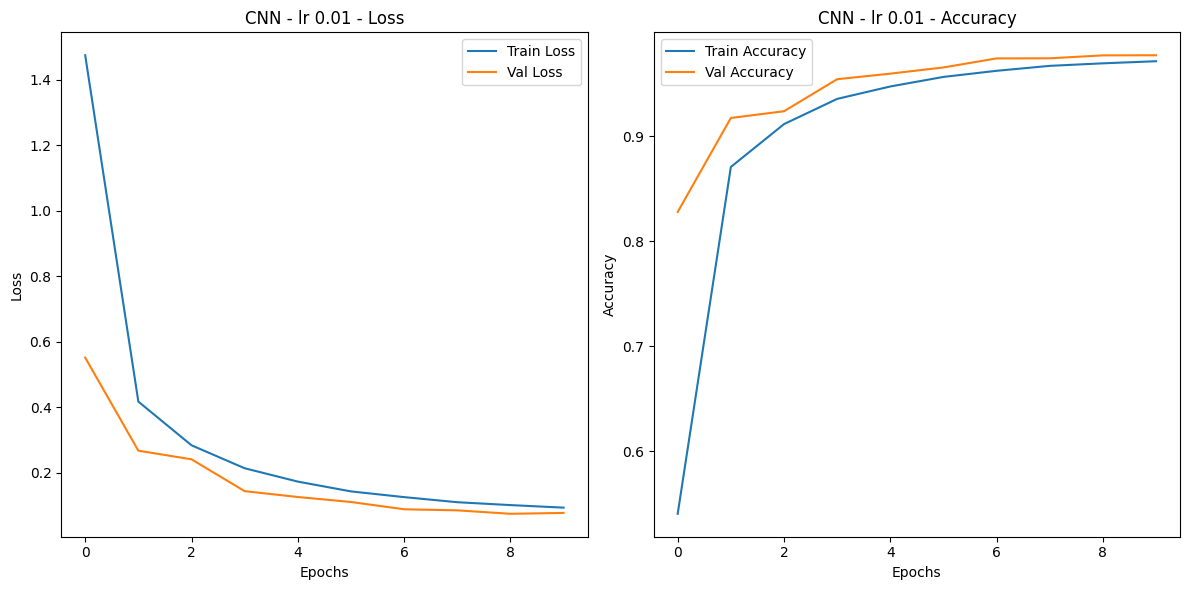


Testing lr: 0.05 for CNN
Epoch 1 - Training Loss: 0.6649, Validation Loss: 0.2057, Validation Accuracy: 0.9336
Epoch 2 - Training Loss: 0.1327, Validation Loss: 0.0796, Validation Accuracy: 0.9766
Epoch 3 - Training Loss: 0.0887, Validation Loss: 0.0977, Validation Accuracy: 0.9711
Epoch 4 - Training Loss: 0.0687, Validation Loss: 0.0533, Validation Accuracy: 0.9853
Epoch 5 - Training Loss: 0.0556, Validation Loss: 0.1223, Validation Accuracy: 0.9610
Epoch 6 - Training Loss: 0.0462, Validation Loss: 0.1130, Validation Accuracy: 0.9668
Epoch 7 - Training Loss: 0.0408, Validation Loss: 0.0426, Validation Accuracy: 0.9880
Epoch 8 - Training Loss: 0.0365, Validation Loss: 0.0412, Validation Accuracy: 0.9880
Epoch 9 - Training Loss: 0.0316, Validation Loss: 0.0403, Validation Accuracy: 0.9883
Epoch 10 - Training Loss: 0.0284, Validation Loss: 0.0407, Validation Accuracy: 0.9879


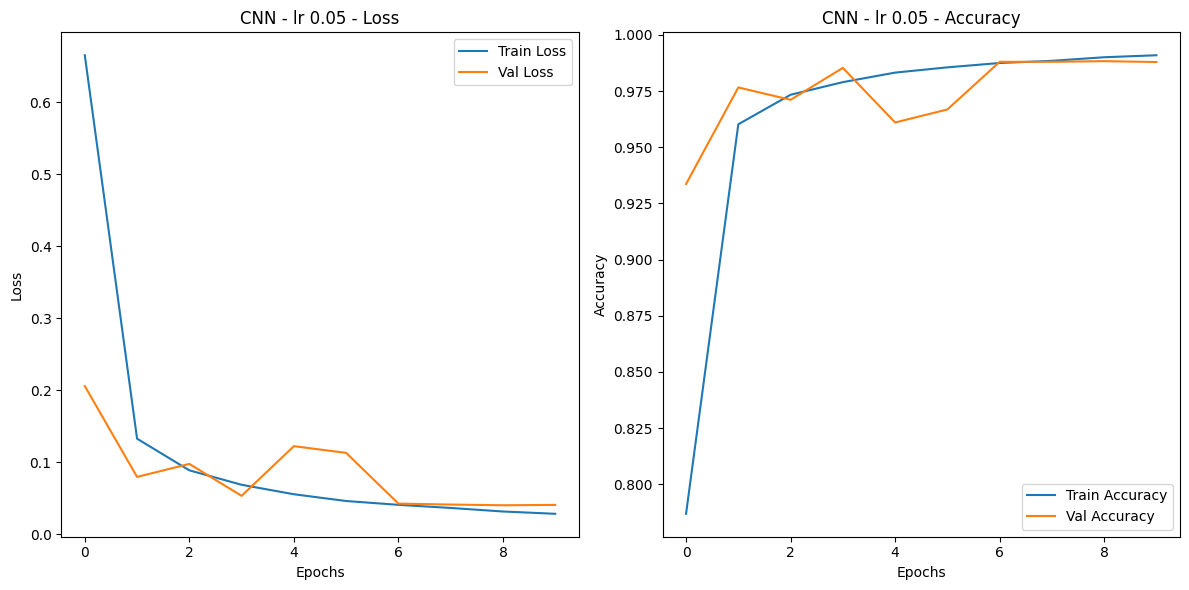


Testing lr: 0.1 for CNN
Epoch 1 - Training Loss: 0.4663, Validation Loss: 0.0947, Validation Accuracy: 0.9722
Epoch 2 - Training Loss: 0.0923, Validation Loss: 0.0998, Validation Accuracy: 0.9721
Epoch 3 - Training Loss: 0.0635, Validation Loss: 0.3199, Validation Accuracy: 0.9071
Epoch 4 - Training Loss: 0.0503, Validation Loss: 0.0531, Validation Accuracy: 0.9850
Epoch 5 - Training Loss: 0.0405, Validation Loss: 0.0405, Validation Accuracy: 0.9884
Epoch 6 - Training Loss: 0.0325, Validation Loss: 0.0437, Validation Accuracy: 0.9878
Epoch 7 - Training Loss: 0.0287, Validation Loss: 0.0446, Validation Accuracy: 0.9880
Epoch 8 - Training Loss: 0.0242, Validation Loss: 0.0360, Validation Accuracy: 0.9900
Epoch 9 - Training Loss: 0.0200, Validation Loss: 0.0362, Validation Accuracy: 0.9894
Epoch 10 - Training Loss: 0.0171, Validation Loss: 0.0394, Validation Accuracy: 0.9899


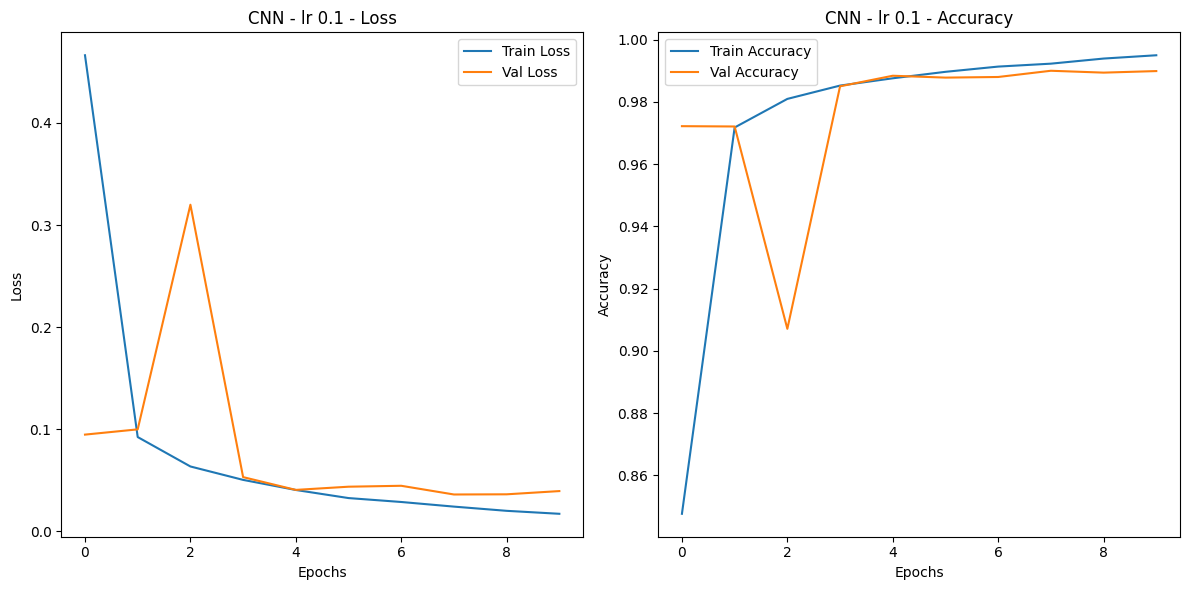

Best CNN lr: 0.1


{'ANN': {'lr': 0.05,
  'batch_size': 64,
  'architecture': [256, 128],
  'val_loss': 0.07777313010119774},
 'CNN': {'lr': 0.1,
  'batch_size': 64,
  'architecture': [256, 128],
  'val_loss': 0.039376807927102124}}

In [ ]:
tune_hyperparameter(learning_rates, "ANN", "lr", best_hyperparams, criterion, epochs=20)
tune_hyperparameter(learning_rates, "CNN", "lr", best_hyperparams, criterion, epochs=10)


Testing batch_size: 32 for ANN
Epoch 1 - Training Loss: 0.5343, Validation Loss: 0.2735, Validation Accuracy: 0.9189
Epoch 2 - Training Loss: 0.2014, Validation Loss: 0.1983, Validation Accuracy: 0.9416
Epoch 3 - Training Loss: 0.1358, Validation Loss: 0.1324, Validation Accuracy: 0.9612
Epoch 4 - Training Loss: 0.1016, Validation Loss: 0.1070, Validation Accuracy: 0.9688
Epoch 5 - Training Loss: 0.0792, Validation Loss: 0.1006, Validation Accuracy: 0.9711
Epoch 6 - Training Loss: 0.0643, Validation Loss: 0.0881, Validation Accuracy: 0.9742
Epoch 7 - Training Loss: 0.0529, Validation Loss: 0.0852, Validation Accuracy: 0.9746
Epoch 8 - Training Loss: 0.0438, Validation Loss: 0.0790, Validation Accuracy: 0.9754
Epoch 9 - Training Loss: 0.0363, Validation Loss: 0.0970, Validation Accuracy: 0.9703
Epoch 10 - Training Loss: 0.0301, Validation Loss: 0.0798, Validation Accuracy: 0.9764
Epoch 11 - Training Loss: 0.0245, Validation Loss: 0.0789, Validation Accuracy: 0.9757
Epoch 12 - Training 

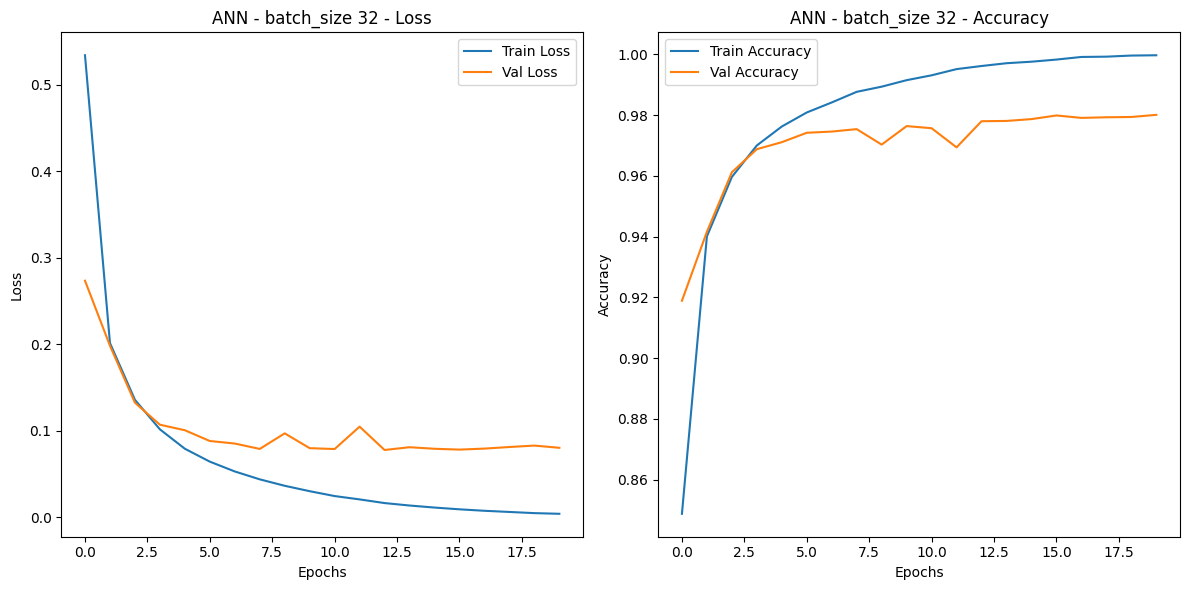


Testing batch_size: 64 for ANN
Epoch 1 - Training Loss: 0.7271, Validation Loss: 0.3551, Validation Accuracy: 0.8953
Epoch 2 - Training Loss: 0.2865, Validation Loss: 0.2557, Validation Accuracy: 0.9276
Epoch 3 - Training Loss: 0.2185, Validation Loss: 0.2223, Validation Accuracy: 0.9334
Epoch 4 - Training Loss: 0.1726, Validation Loss: 0.1858, Validation Accuracy: 0.9439
Epoch 5 - Training Loss: 0.1407, Validation Loss: 0.1540, Validation Accuracy: 0.9553
Epoch 6 - Training Loss: 0.1168, Validation Loss: 0.1338, Validation Accuracy: 0.9609
Epoch 7 - Training Loss: 0.1004, Validation Loss: 0.1666, Validation Accuracy: 0.9501
Epoch 8 - Training Loss: 0.0871, Validation Loss: 0.1136, Validation Accuracy: 0.9668
Epoch 9 - Training Loss: 0.0760, Validation Loss: 0.1053, Validation Accuracy: 0.9687
Epoch 10 - Training Loss: 0.0664, Validation Loss: 0.1112, Validation Accuracy: 0.9658
Epoch 11 - Training Loss: 0.0591, Validation Loss: 0.1008, Validation Accuracy: 0.9698
Epoch 12 - Training 

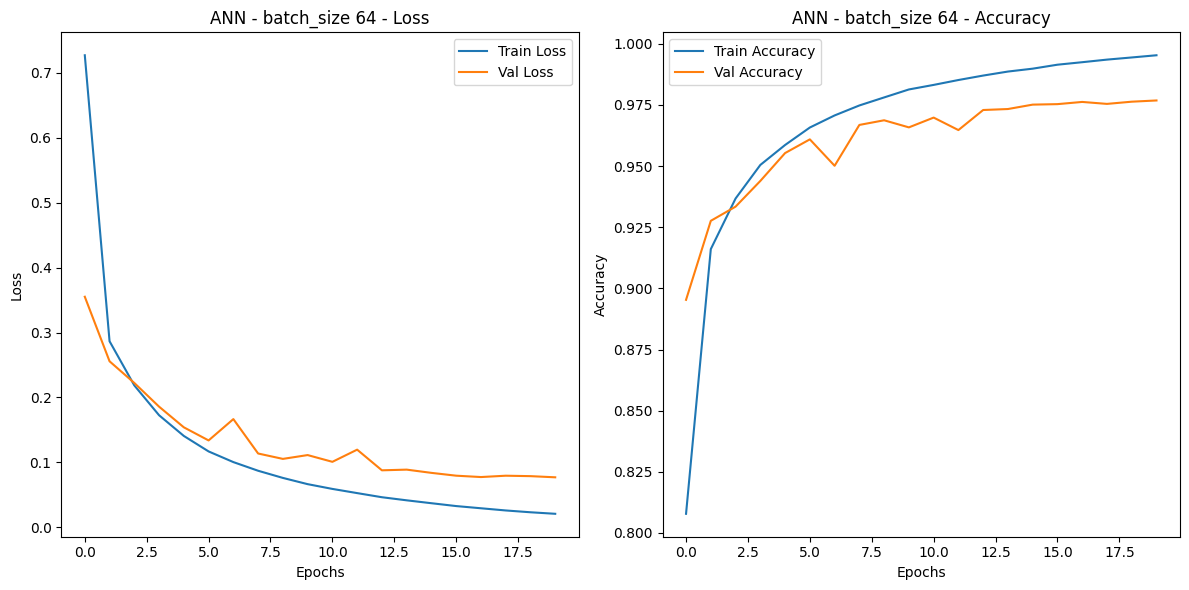


Testing batch_size: 128 for ANN
Epoch 1 - Training Loss: 1.0899, Validation Loss: 0.4313, Validation Accuracy: 0.8781
Epoch 2 - Training Loss: 0.3658, Validation Loss: 0.3260, Validation Accuracy: 0.9086
Epoch 3 - Training Loss: 0.2983, Validation Loss: 0.2819, Validation Accuracy: 0.9185
Epoch 4 - Training Loss: 0.2578, Validation Loss: 0.2538, Validation Accuracy: 0.9254
Epoch 5 - Training Loss: 0.2251, Validation Loss: 0.2254, Validation Accuracy: 0.9335
Epoch 6 - Training Loss: 0.2011, Validation Loss: 0.2080, Validation Accuracy: 0.9413
Epoch 7 - Training Loss: 0.1797, Validation Loss: 0.1879, Validation Accuracy: 0.9450
Epoch 8 - Training Loss: 0.1615, Validation Loss: 0.1745, Validation Accuracy: 0.9508
Epoch 9 - Training Loss: 0.1466, Validation Loss: 0.1598, Validation Accuracy: 0.9541
Epoch 10 - Training Loss: 0.1329, Validation Loss: 0.1486, Validation Accuracy: 0.9579
Epoch 11 - Training Loss: 0.1216, Validation Loss: 0.1450, Validation Accuracy: 0.9576
Epoch 12 - Training

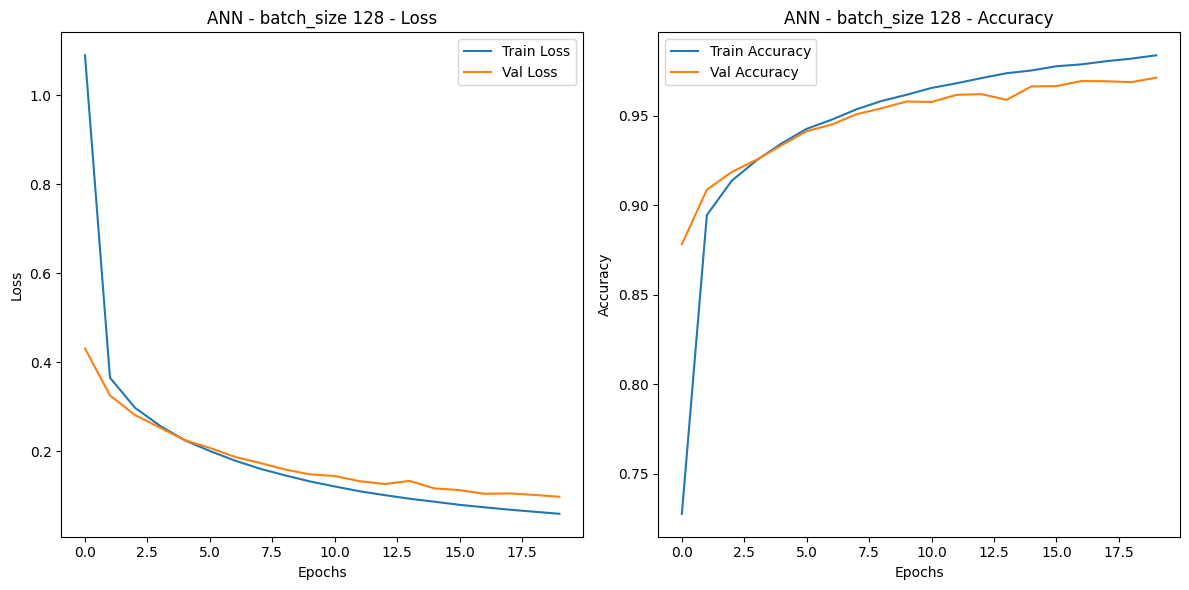


Testing batch_size: 256 for ANN
Epoch 1 - Training Loss: 1.6396, Validation Loss: 0.7507, Validation Accuracy: 0.8000
Epoch 2 - Training Loss: 0.5459, Validation Loss: 0.4410, Validation Accuracy: 0.8768
Epoch 3 - Training Loss: 0.3960, Validation Loss: 0.3678, Validation Accuracy: 0.8916
Epoch 4 - Training Loss: 0.3441, Validation Loss: 0.3285, Validation Accuracy: 0.9056
Epoch 5 - Training Loss: 0.3129, Validation Loss: 0.3241, Validation Accuracy: 0.9071
Epoch 6 - Training Loss: 0.2895, Validation Loss: 0.2897, Validation Accuracy: 0.9154
Epoch 7 - Training Loss: 0.2693, Validation Loss: 0.2673, Validation Accuracy: 0.9222
Epoch 8 - Training Loss: 0.2512, Validation Loss: 0.2508, Validation Accuracy: 0.9266
Epoch 9 - Training Loss: 0.2353, Validation Loss: 0.2464, Validation Accuracy: 0.9270
Epoch 10 - Training Loss: 0.2215, Validation Loss: 0.2342, Validation Accuracy: 0.9315
Epoch 11 - Training Loss: 0.2080, Validation Loss: 0.2149, Validation Accuracy: 0.9389
Epoch 12 - Training

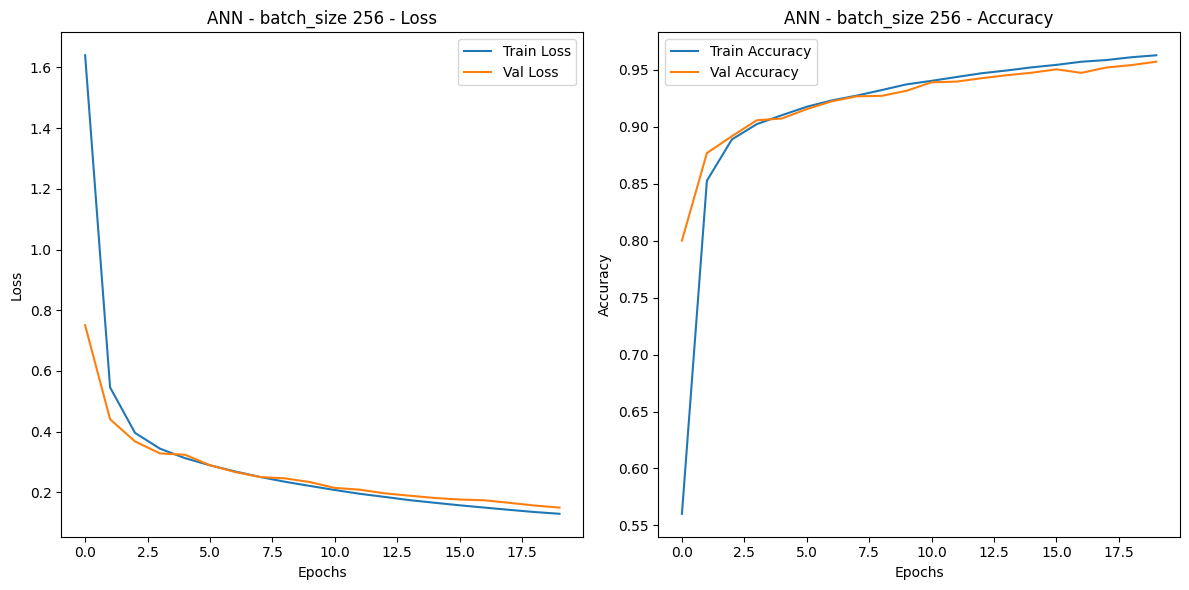

Best ANN batch_size: 64

Testing batch_size: 32 for CNN
Epoch 1 - Training Loss: 0.3226, Validation Loss: 0.0820, Validation Accuracy: 0.9747
Epoch 2 - Training Loss: 0.0750, Validation Loss: 0.0500, Validation Accuracy: 0.9858
Epoch 3 - Training Loss: 0.0502, Validation Loss: 0.0424, Validation Accuracy: 0.9882
Epoch 4 - Training Loss: 0.0378, Validation Loss: 0.0414, Validation Accuracy: 0.9873
Epoch 5 - Training Loss: 0.0311, Validation Loss: 0.0375, Validation Accuracy: 0.9887
Epoch 6 - Training Loss: 0.0241, Validation Loss: 0.0381, Validation Accuracy: 0.9891
Epoch 7 - Training Loss: 0.0204, Validation Loss: 0.0430, Validation Accuracy: 0.9890
Epoch 8 - Training Loss: 0.0172, Validation Loss: 0.0412, Validation Accuracy: 0.9875
Epoch 9 - Training Loss: 0.0148, Validation Loss: 0.0427, Validation Accuracy: 0.9894
Epoch 10 - Training Loss: 0.0125, Validation Loss: 0.0475, Validation Accuracy: 0.9884


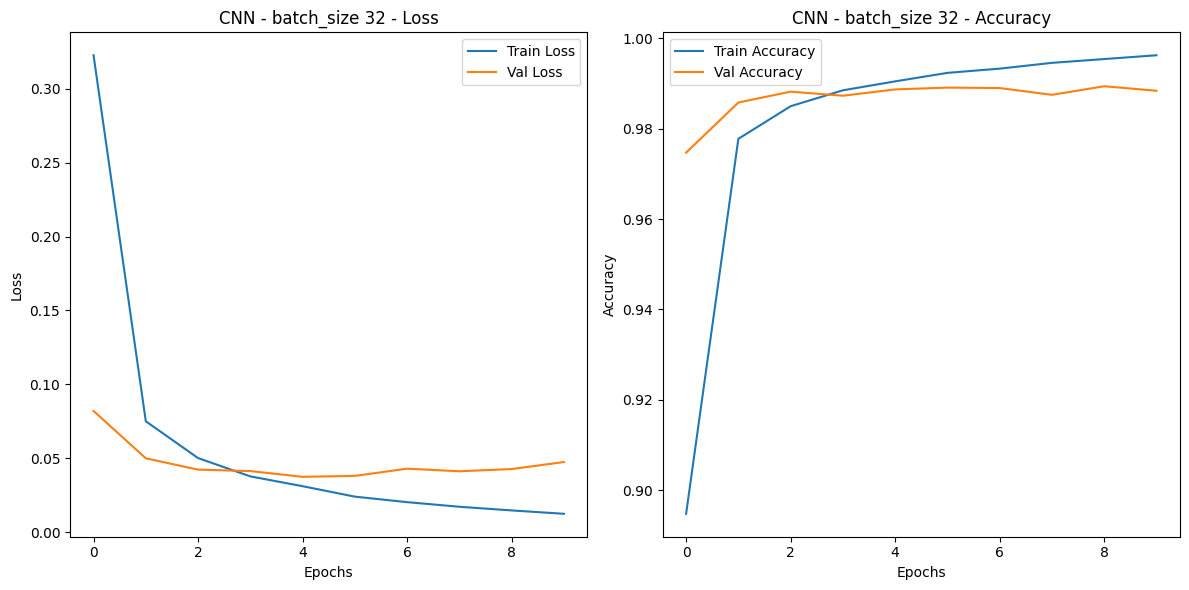


Testing batch_size: 64 for CNN
Epoch 1 - Training Loss: 0.4375, Validation Loss: 0.1002, Validation Accuracy: 0.9687
Epoch 2 - Training Loss: 0.0958, Validation Loss: 0.0664, Validation Accuracy: 0.9815
Epoch 3 - Training Loss: 0.0649, Validation Loss: 0.0632, Validation Accuracy: 0.9815
Epoch 4 - Training Loss: 0.0498, Validation Loss: 0.0469, Validation Accuracy: 0.9859
Epoch 5 - Training Loss: 0.0417, Validation Loss: 0.0400, Validation Accuracy: 0.9883
Epoch 6 - Training Loss: 0.0342, Validation Loss: 0.0382, Validation Accuracy: 0.9893
Epoch 7 - Training Loss: 0.0273, Validation Loss: 0.0434, Validation Accuracy: 0.9893
Epoch 8 - Training Loss: 0.0260, Validation Loss: 0.0398, Validation Accuracy: 0.9891
Epoch 9 - Training Loss: 0.0211, Validation Loss: 0.0406, Validation Accuracy: 0.9873
Epoch 10 - Training Loss: 0.0203, Validation Loss: 0.0413, Validation Accuracy: 0.9900


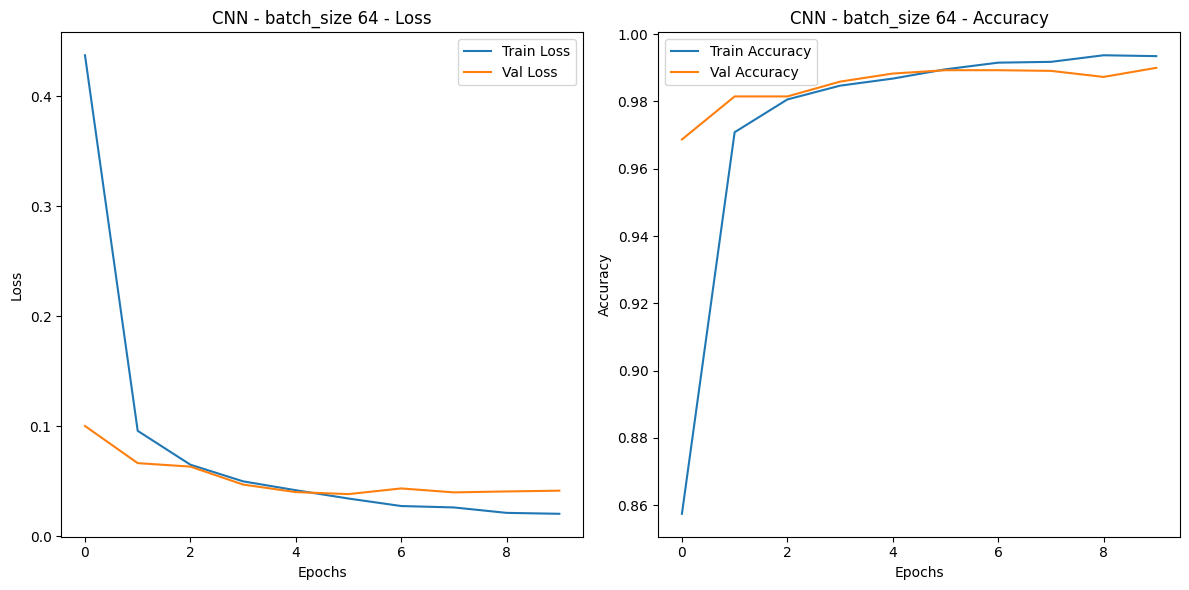


Testing batch_size: 128 for CNN
Epoch 1 - Training Loss: 0.6918, Validation Loss: 0.1522, Validation Accuracy: 0.9533
Epoch 2 - Training Loss: 0.1326, Validation Loss: 0.0903, Validation Accuracy: 0.9727
Epoch 3 - Training Loss: 0.0882, Validation Loss: 0.0751, Validation Accuracy: 0.9779
Epoch 4 - Training Loss: 0.0701, Validation Loss: 0.0666, Validation Accuracy: 0.9803
Epoch 5 - Training Loss: 0.0566, Validation Loss: 0.0581, Validation Accuracy: 0.9827
Epoch 6 - Training Loss: 0.0478, Validation Loss: 0.0442, Validation Accuracy: 0.9878
Epoch 7 - Training Loss: 0.0428, Validation Loss: 0.0443, Validation Accuracy: 0.9869
Epoch 8 - Training Loss: 0.0370, Validation Loss: 0.0426, Validation Accuracy: 0.9873
Epoch 9 - Training Loss: 0.0339, Validation Loss: 0.0483, Validation Accuracy: 0.9869
Epoch 10 - Training Loss: 0.0298, Validation Loss: 0.0403, Validation Accuracy: 0.9889


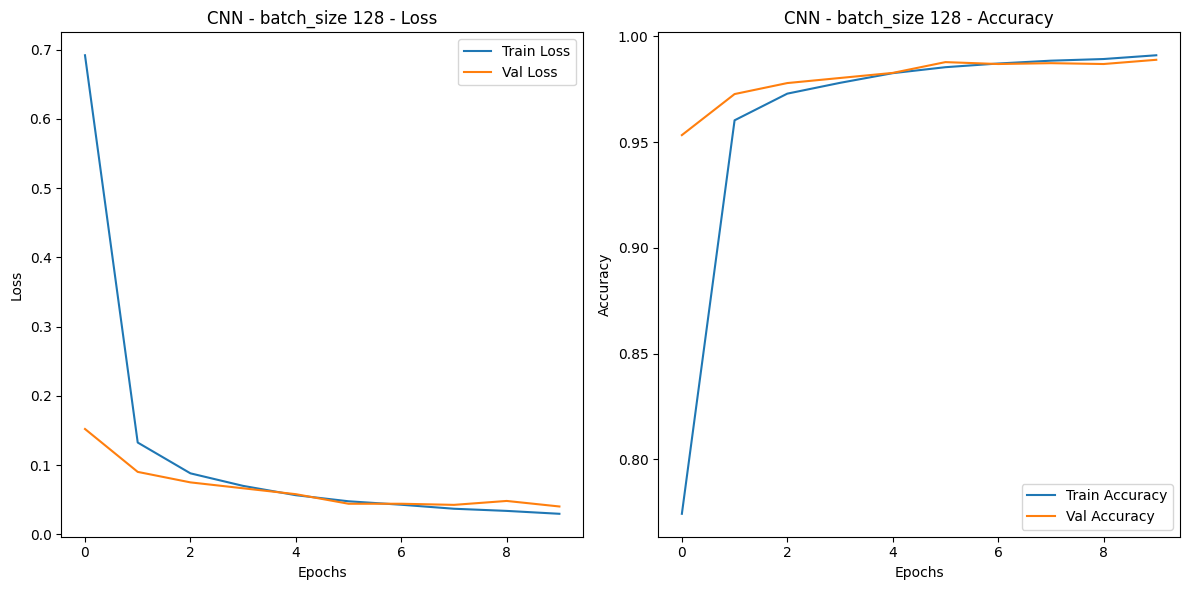


Testing batch_size: 256 for CNN
Epoch 1 - Training Loss: 1.0756, Validation Loss: 0.2696, Validation Accuracy: 0.9127
Epoch 2 - Training Loss: 0.2176, Validation Loss: 0.1296, Validation Accuracy: 0.9592
Epoch 3 - Training Loss: 0.1318, Validation Loss: 0.0822, Validation Accuracy: 0.9755
Epoch 4 - Training Loss: 0.1006, Validation Loss: 0.0834, Validation Accuracy: 0.9751
Epoch 5 - Training Loss: 0.0821, Validation Loss: 0.0792, Validation Accuracy: 0.9747
Epoch 6 - Training Loss: 0.0692, Validation Loss: 0.0641, Validation Accuracy: 0.9807
Epoch 7 - Training Loss: 0.0632, Validation Loss: 0.0618, Validation Accuracy: 0.9804
Epoch 8 - Training Loss: 0.0551, Validation Loss: 0.0542, Validation Accuracy: 0.9826
Epoch 9 - Training Loss: 0.0496, Validation Loss: 0.0484, Validation Accuracy: 0.9863
Epoch 10 - Training Loss: 0.0456, Validation Loss: 0.0456, Validation Accuracy: 0.9865


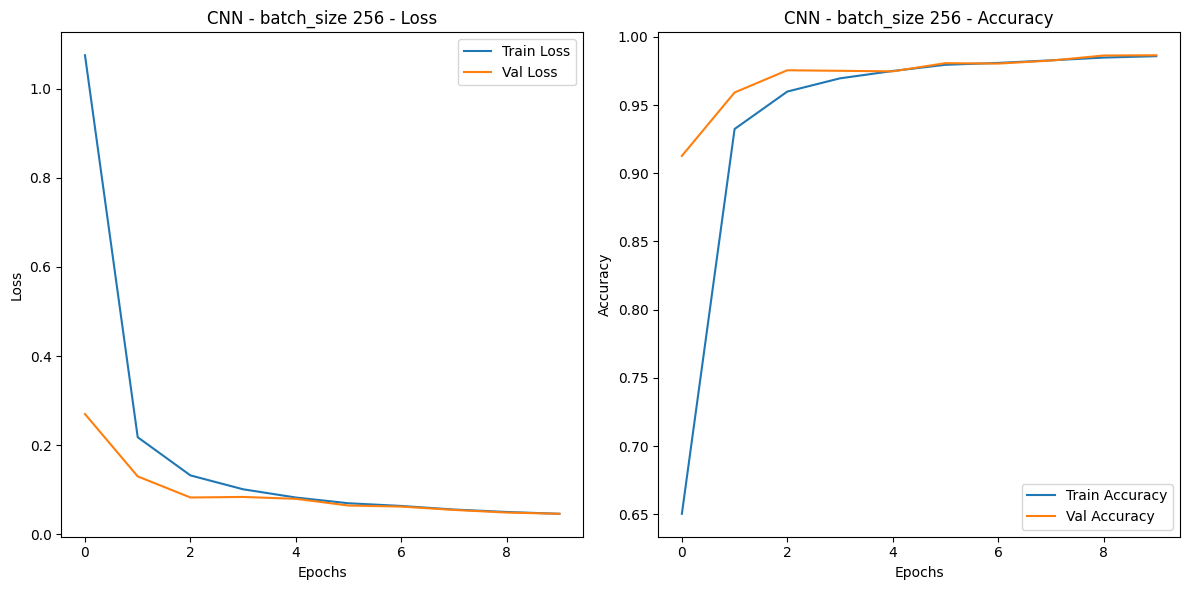

Best CNN batch_size: 64


{'ANN': {'lr': 0.05,
  'batch_size': 64,
  'architecture': [256, 128],
  'val_loss': 0.07696061087127146},
 'CNN': {'lr': 0.1,
  'batch_size': 64,
  'architecture': [256, 128],
  'val_loss': 0.039376807927102124}}

In [ ]:
tune_hyperparameter(batch_sizes, "ANN", "batch_size", best_hyperparams, criterion, epochs=20)
tune_hyperparameter(batch_sizes, "CNN", "batch_size", best_hyperparams, criterion, epochs=10)


Testing architecture: [64, 32] for ANN
Epoch 1 - Training Loss: 0.8024, Validation Loss: 0.3505, Validation Accuracy: 0.8985
Epoch 2 - Training Loss: 0.3081, Validation Loss: 0.3944, Validation Accuracy: 0.8842
Epoch 3 - Training Loss: 0.2405, Validation Loss: 0.2348, Validation Accuracy: 0.9310
Epoch 4 - Training Loss: 0.1964, Validation Loss: 0.2171, Validation Accuracy: 0.9342
Epoch 5 - Training Loss: 0.1662, Validation Loss: 0.1824, Validation Accuracy: 0.9479
Epoch 6 - Training Loss: 0.1440, Validation Loss: 0.1515, Validation Accuracy: 0.9577
Epoch 7 - Training Loss: 0.1270, Validation Loss: 0.1435, Validation Accuracy: 0.9572
Epoch 8 - Training Loss: 0.1126, Validation Loss: 0.1824, Validation Accuracy: 0.9390
Epoch 9 - Training Loss: 0.1007, Validation Loss: 0.1501, Validation Accuracy: 0.9540
Epoch 10 - Training Loss: 0.0916, Validation Loss: 0.1181, Validation Accuracy: 0.9648
Epoch 11 - Training Loss: 0.0829, Validation Loss: 0.1146, Validation Accuracy: 0.9648
Epoch 12 - T

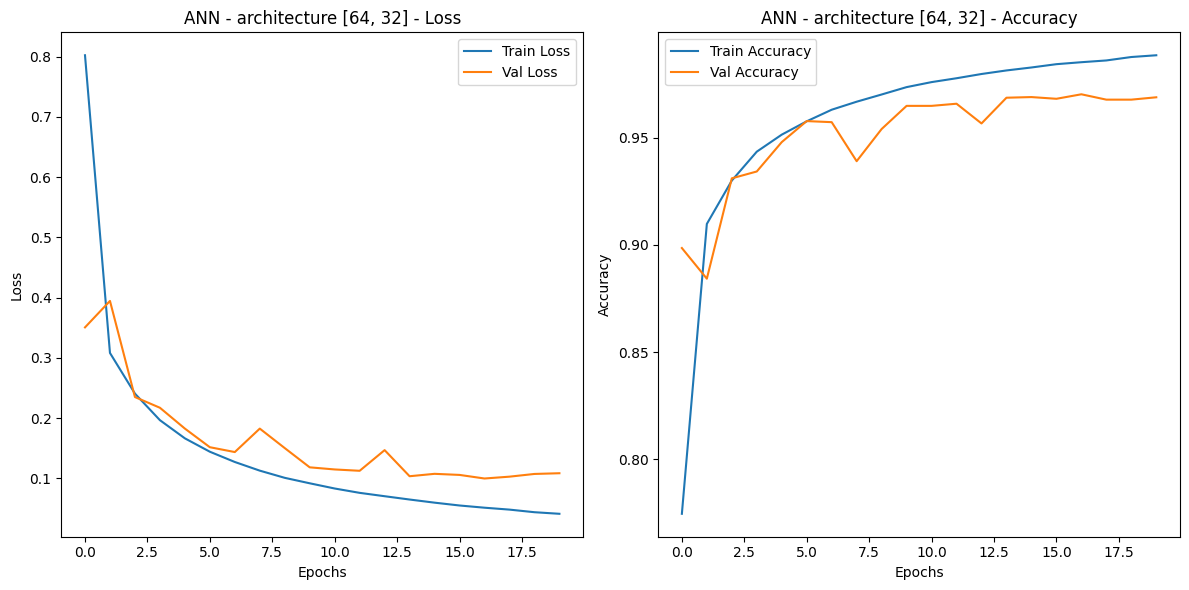


Testing architecture: [128, 64] for ANN
Epoch 1 - Training Loss: 0.7347, Validation Loss: 0.4580, Validation Accuracy: 0.8657
Epoch 2 - Training Loss: 0.2900, Validation Loss: 0.2686, Validation Accuracy: 0.9252
Epoch 3 - Training Loss: 0.2257, Validation Loss: 0.3044, Validation Accuracy: 0.9027
Epoch 4 - Training Loss: 0.1812, Validation Loss: 0.1949, Validation Accuracy: 0.9429
Epoch 5 - Training Loss: 0.1519, Validation Loss: 0.1861, Validation Accuracy: 0.9430
Epoch 6 - Training Loss: 0.1289, Validation Loss: 0.1396, Validation Accuracy: 0.9593
Epoch 7 - Training Loss: 0.1115, Validation Loss: 0.1316, Validation Accuracy: 0.9622
Epoch 8 - Training Loss: 0.0977, Validation Loss: 0.1266, Validation Accuracy: 0.9618
Epoch 9 - Training Loss: 0.0871, Validation Loss: 0.1210, Validation Accuracy: 0.9644
Epoch 10 - Training Loss: 0.0777, Validation Loss: 0.1064, Validation Accuracy: 0.9683
Epoch 11 - Training Loss: 0.0694, Validation Loss: 0.1027, Validation Accuracy: 0.9686
Epoch 12 - 

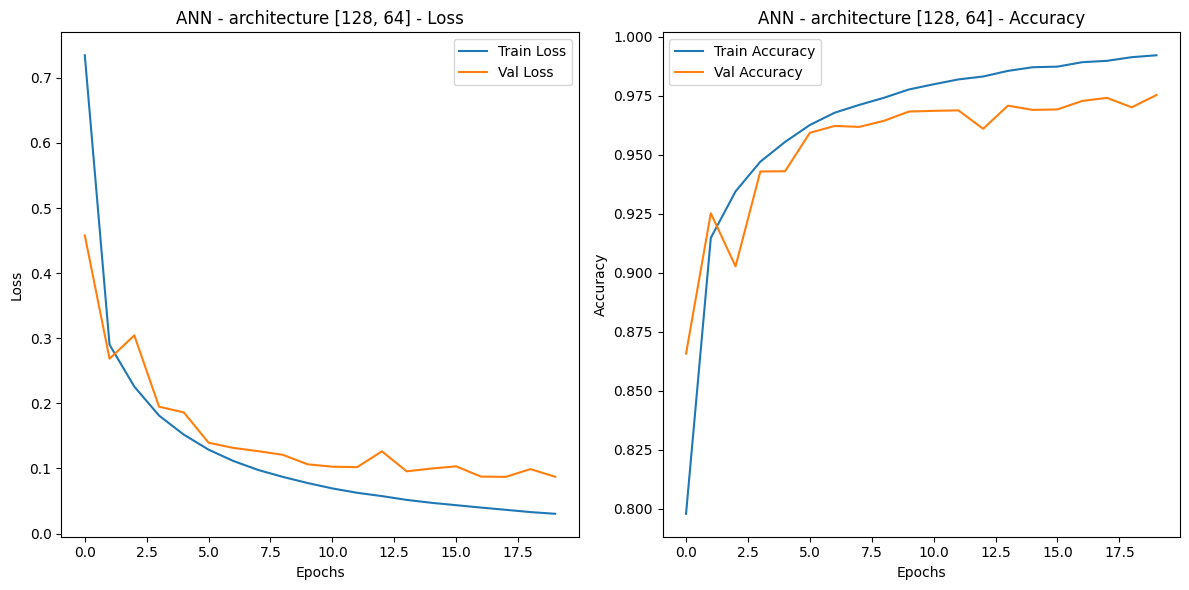


Testing architecture: [256, 128] for ANN
Epoch 1 - Training Loss: 0.7624, Validation Loss: 0.3792, Validation Accuracy: 0.8888
Epoch 2 - Training Loss: 0.2891, Validation Loss: 0.2899, Validation Accuracy: 0.9150
Epoch 3 - Training Loss: 0.2200, Validation Loss: 0.2309, Validation Accuracy: 0.9318
Epoch 4 - Training Loss: 0.1717, Validation Loss: 0.1834, Validation Accuracy: 0.9474
Epoch 5 - Training Loss: 0.1395, Validation Loss: 0.1560, Validation Accuracy: 0.9544
Epoch 6 - Training Loss: 0.1160, Validation Loss: 0.1501, Validation Accuracy: 0.9578
Epoch 7 - Training Loss: 0.0996, Validation Loss: 0.1728, Validation Accuracy: 0.9457
Epoch 8 - Training Loss: 0.0860, Validation Loss: 0.1163, Validation Accuracy: 0.9660
Epoch 9 - Training Loss: 0.0751, Validation Loss: 0.1018, Validation Accuracy: 0.9684
Epoch 10 - Training Loss: 0.0659, Validation Loss: 0.1023, Validation Accuracy: 0.9696
Epoch 11 - Training Loss: 0.0581, Validation Loss: 0.1016, Validation Accuracy: 0.9695
Epoch 12 -

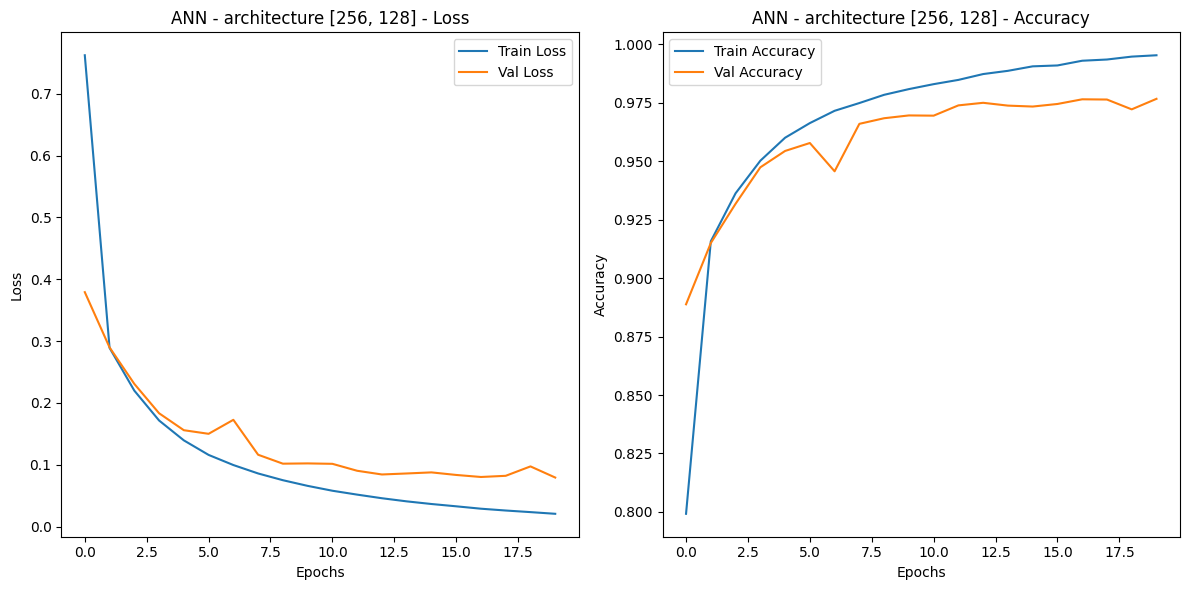


Testing architecture: [512, 256] for ANN
Epoch 1 - Training Loss: 0.7077, Validation Loss: 0.3238, Validation Accuracy: 0.9079
Epoch 2 - Training Loss: 0.2795, Validation Loss: 0.2989, Validation Accuracy: 0.9085
Epoch 3 - Training Loss: 0.2112, Validation Loss: 0.2138, Validation Accuracy: 0.9384
Epoch 4 - Training Loss: 0.1666, Validation Loss: 0.1766, Validation Accuracy: 0.9498
Epoch 5 - Training Loss: 0.1347, Validation Loss: 0.1422, Validation Accuracy: 0.9584
Epoch 6 - Training Loss: 0.1122, Validation Loss: 0.1469, Validation Accuracy: 0.9571
Epoch 7 - Training Loss: 0.0950, Validation Loss: 0.1146, Validation Accuracy: 0.9660
Epoch 8 - Training Loss: 0.0817, Validation Loss: 0.1042, Validation Accuracy: 0.9698
Epoch 9 - Training Loss: 0.0705, Validation Loss: 0.0957, Validation Accuracy: 0.9720
Epoch 10 - Training Loss: 0.0612, Validation Loss: 0.1012, Validation Accuracy: 0.9677
Epoch 11 - Training Loss: 0.0540, Validation Loss: 0.1140, Validation Accuracy: 0.9648
Epoch 12 -

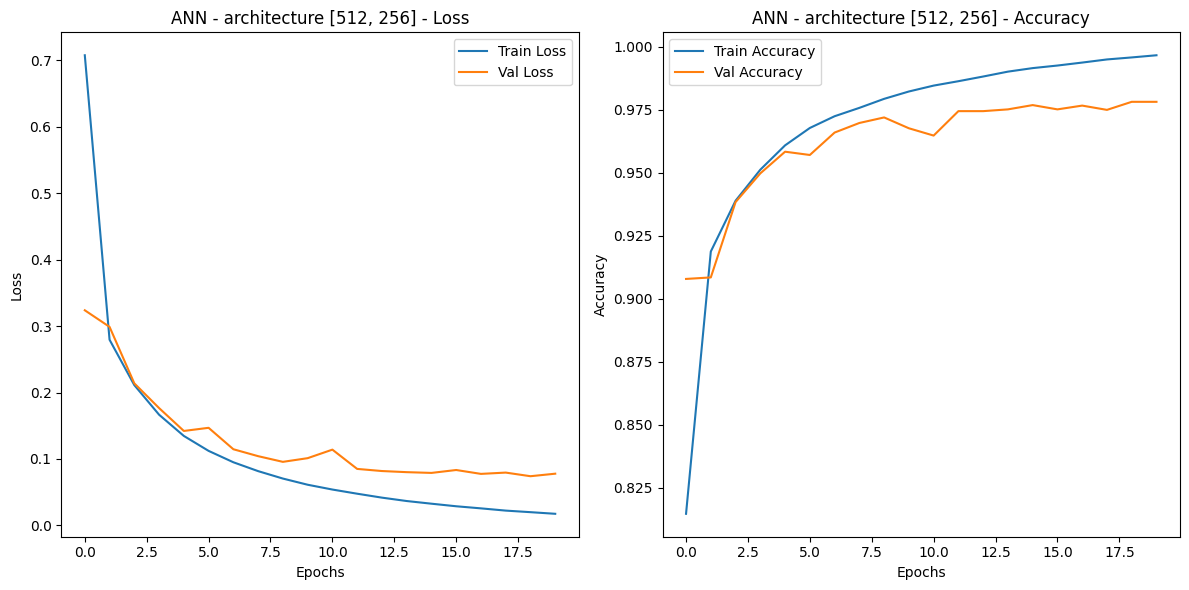


Testing architecture: [256] for ANN
Epoch 1 - Training Loss: 0.6134, Validation Loss: 0.3399, Validation Accuracy: 0.9062
Epoch 2 - Training Loss: 0.3004, Validation Loss: 0.2881, Validation Accuracy: 0.9170
Epoch 3 - Training Loss: 0.2485, Validation Loss: 0.2377, Validation Accuracy: 0.9319
Epoch 4 - Training Loss: 0.2115, Validation Loss: 0.2157, Validation Accuracy: 0.9377
Epoch 5 - Training Loss: 0.1843, Validation Loss: 0.1888, Validation Accuracy: 0.9479
Epoch 6 - Training Loss: 0.1638, Validation Loss: 0.1745, Validation Accuracy: 0.9531
Epoch 7 - Training Loss: 0.1466, Validation Loss: 0.1719, Validation Accuracy: 0.9518
Epoch 8 - Training Loss: 0.1330, Validation Loss: 0.1510, Validation Accuracy: 0.9576
Epoch 9 - Training Loss: 0.1211, Validation Loss: 0.1435, Validation Accuracy: 0.9600
Epoch 10 - Training Loss: 0.1115, Validation Loss: 0.1362, Validation Accuracy: 0.9627
Epoch 11 - Training Loss: 0.1027, Validation Loss: 0.1306, Validation Accuracy: 0.9619
Epoch 12 - Trai

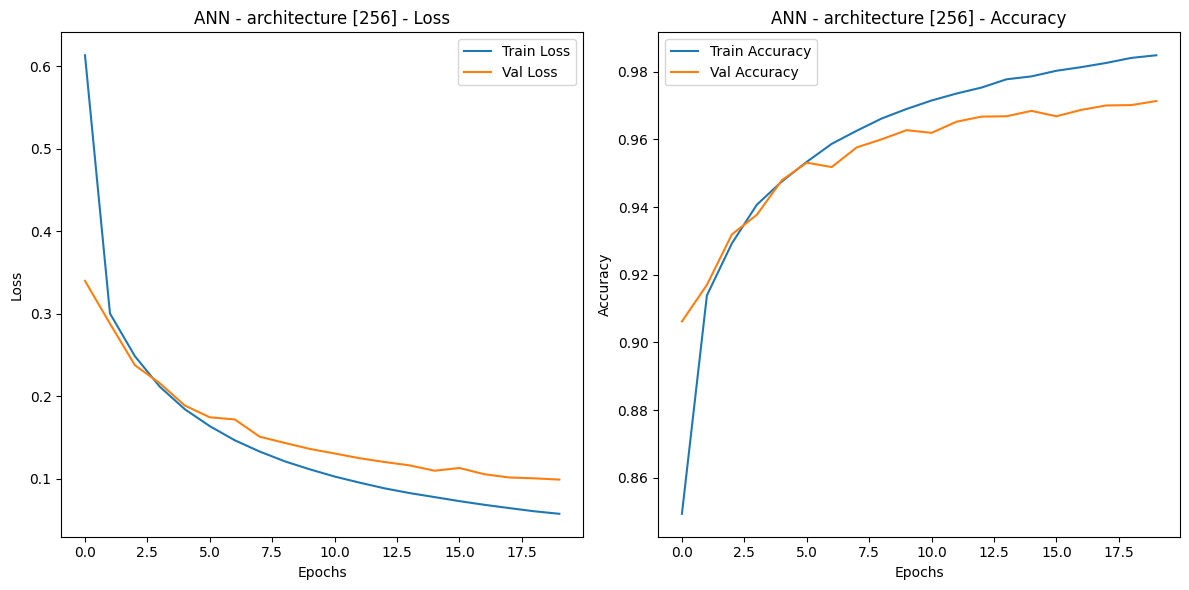


Testing architecture: [256, 128] for ANN
Epoch 1 - Training Loss: 0.7426, Validation Loss: 0.4034, Validation Accuracy: 0.8795
Epoch 2 - Training Loss: 0.2877, Validation Loss: 0.2798, Validation Accuracy: 0.9184
Epoch 3 - Training Loss: 0.2178, Validation Loss: 0.2190, Validation Accuracy: 0.9366
Epoch 4 - Training Loss: 0.1727, Validation Loss: 0.1719, Validation Accuracy: 0.9502
Epoch 5 - Training Loss: 0.1414, Validation Loss: 0.1864, Validation Accuracy: 0.9434
Epoch 6 - Training Loss: 0.1186, Validation Loss: 0.1317, Validation Accuracy: 0.9619
Epoch 7 - Training Loss: 0.1011, Validation Loss: 0.1237, Validation Accuracy: 0.9640
Epoch 8 - Training Loss: 0.0879, Validation Loss: 0.1316, Validation Accuracy: 0.9618
Epoch 9 - Training Loss: 0.0773, Validation Loss: 0.1043, Validation Accuracy: 0.9683
Epoch 10 - Training Loss: 0.0669, Validation Loss: 0.0973, Validation Accuracy: 0.9713
Epoch 11 - Training Loss: 0.0597, Validation Loss: 0.0943, Validation Accuracy: 0.9732
Epoch 12 -

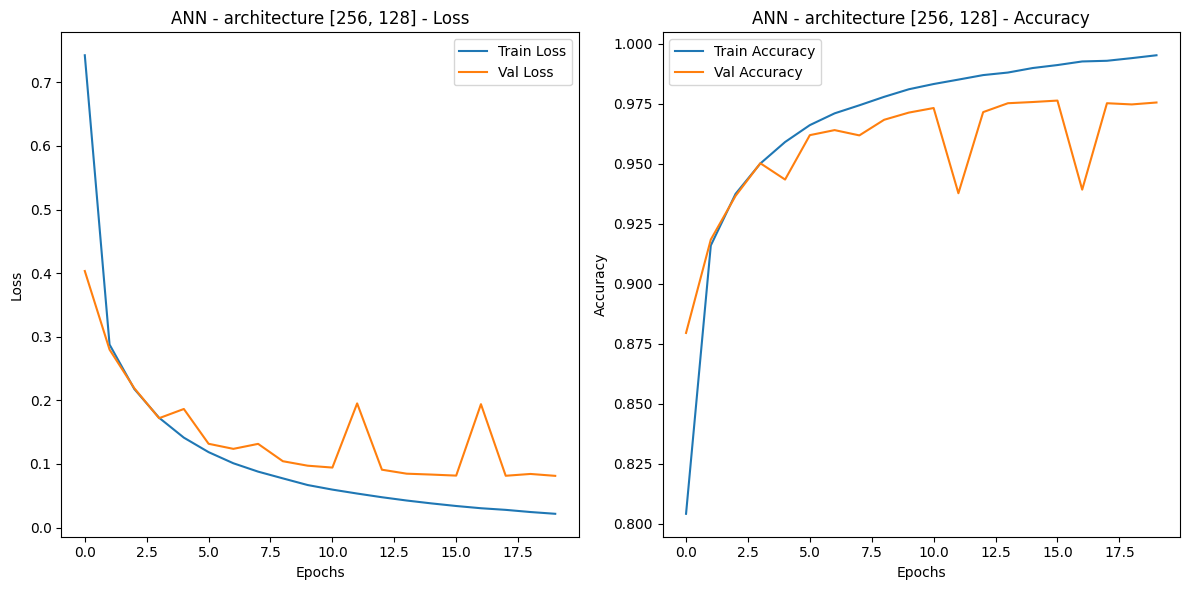


Testing architecture: [256, 128, 64] for ANN
Epoch 1 - Training Loss: 1.0324, Validation Loss: 0.6029, Validation Accuracy: 0.8125
Epoch 2 - Training Loss: 0.3047, Validation Loss: 0.2400, Validation Accuracy: 0.9278
Epoch 3 - Training Loss: 0.1972, Validation Loss: 0.1832, Validation Accuracy: 0.9452
Epoch 4 - Training Loss: 0.1466, Validation Loss: 0.1696, Validation Accuracy: 0.9481
Epoch 5 - Training Loss: 0.1144, Validation Loss: 0.1362, Validation Accuracy: 0.9604
Epoch 6 - Training Loss: 0.0941, Validation Loss: 0.1165, Validation Accuracy: 0.9654
Epoch 7 - Training Loss: 0.0786, Validation Loss: 0.1209, Validation Accuracy: 0.9632
Epoch 8 - Training Loss: 0.0655, Validation Loss: 0.0968, Validation Accuracy: 0.9720
Epoch 9 - Training Loss: 0.0556, Validation Loss: 0.0912, Validation Accuracy: 0.9726
Epoch 10 - Training Loss: 0.0471, Validation Loss: 0.0928, Validation Accuracy: 0.9720
Epoch 11 - Training Loss: 0.0400, Validation Loss: 0.0947, Validation Accuracy: 0.9736
Epoch 

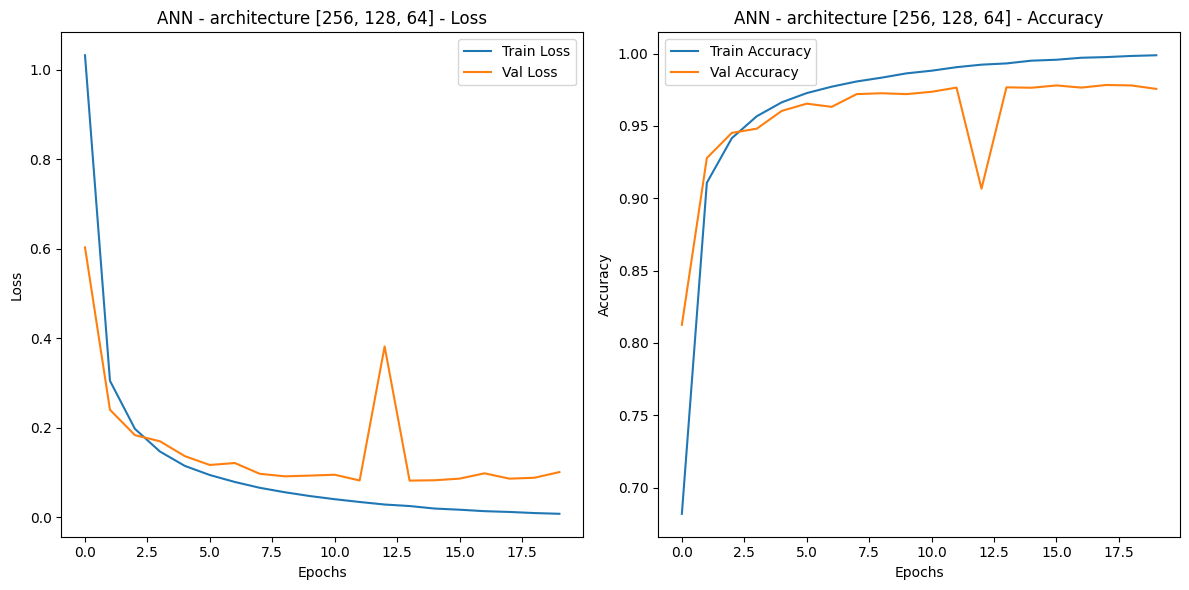


Testing architecture: [256, 128, 64, 32] for ANN
Epoch 1 - Training Loss: 1.6146, Validation Loss: 0.6865, Validation Accuracy: 0.7955
Epoch 2 - Training Loss: 0.3944, Validation Loss: 0.3094, Validation Accuracy: 0.9096
Epoch 3 - Training Loss: 0.2062, Validation Loss: 0.1685, Validation Accuracy: 0.9493
Epoch 4 - Training Loss: 0.1411, Validation Loss: 0.1449, Validation Accuracy: 0.9593
Epoch 5 - Training Loss: 0.1063, Validation Loss: 0.1441, Validation Accuracy: 0.9573
Epoch 6 - Training Loss: 0.0846, Validation Loss: 0.1337, Validation Accuracy: 0.9636
Epoch 7 - Training Loss: 0.0674, Validation Loss: 0.1400, Validation Accuracy: 0.9594
Epoch 8 - Training Loss: 0.0560, Validation Loss: 0.0987, Validation Accuracy: 0.9744
Epoch 9 - Training Loss: 0.0455, Validation Loss: 0.1321, Validation Accuracy: 0.9624
Epoch 10 - Training Loss: 0.0369, Validation Loss: 0.0994, Validation Accuracy: 0.9728
Epoch 11 - Training Loss: 0.0309, Validation Loss: 0.1287, Validation Accuracy: 0.9645
Ep

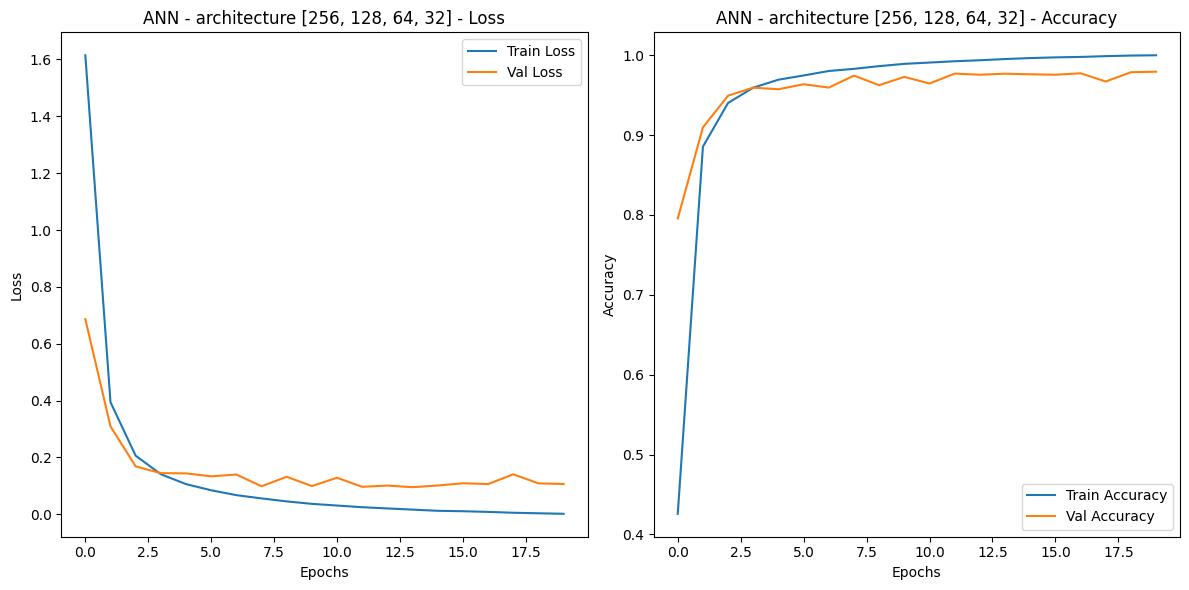

Best ANN architecture: [512, 256]

Testing architecture: [64, 32] for CNN
Epoch 1 - Training Loss: 0.6405, Validation Loss: 0.1462, Validation Accuracy: 0.9557
Epoch 2 - Training Loss: 0.1623, Validation Loss: 0.0697, Validation Accuracy: 0.9803
Epoch 3 - Training Loss: 0.1114, Validation Loss: 0.0683, Validation Accuracy: 0.9819
Epoch 4 - Training Loss: 0.0918, Validation Loss: 0.0634, Validation Accuracy: 0.9818
Epoch 5 - Training Loss: 0.0779, Validation Loss: 0.0547, Validation Accuracy: 0.9858
Epoch 6 - Training Loss: 0.0704, Validation Loss: 0.0565, Validation Accuracy: 0.9843
Epoch 7 - Training Loss: 0.0592, Validation Loss: 0.0644, Validation Accuracy: 0.9826
Epoch 8 - Training Loss: 0.0535, Validation Loss: 0.0561, Validation Accuracy: 0.9879
Epoch 9 - Training Loss: 0.0476, Validation Loss: 0.0524, Validation Accuracy: 0.9871
Epoch 10 - Training Loss: 0.0470, Validation Loss: 0.0555, Validation Accuracy: 0.9870


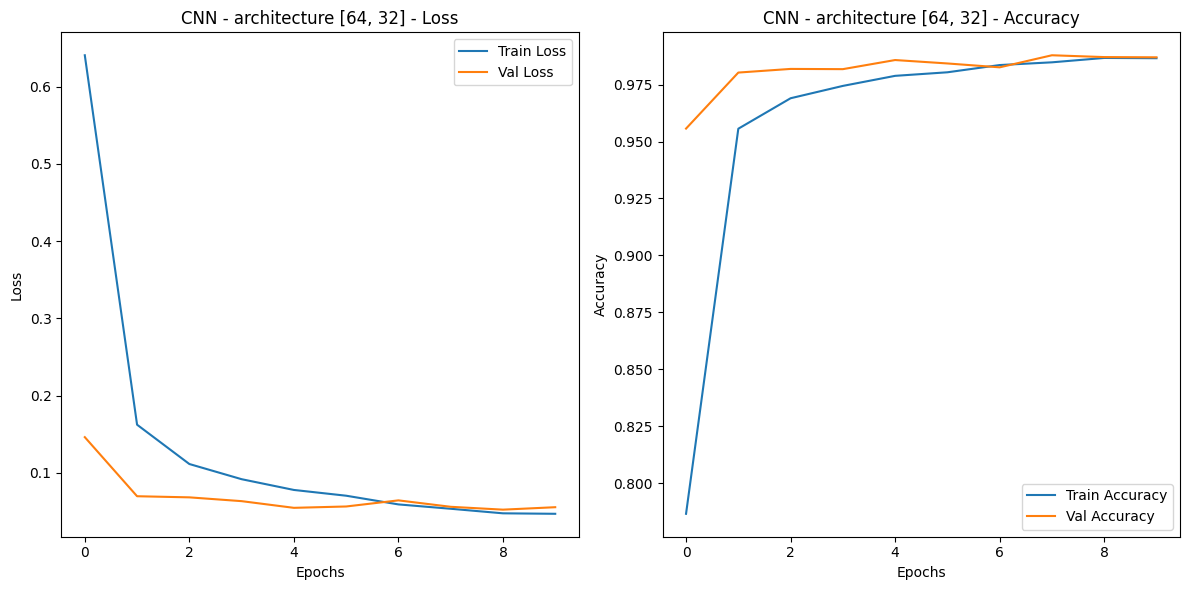


Testing architecture: [128, 64] for CNN
Epoch 1 - Training Loss: 0.5447, Validation Loss: 0.0920, Validation Accuracy: 0.9726
Epoch 2 - Training Loss: 0.1103, Validation Loss: 0.0999, Validation Accuracy: 0.9715
Epoch 3 - Training Loss: 0.0800, Validation Loss: 0.0524, Validation Accuracy: 0.9850
Epoch 4 - Training Loss: 0.0587, Validation Loss: 0.0478, Validation Accuracy: 0.9869
Epoch 5 - Training Loss: 0.0509, Validation Loss: 0.0449, Validation Accuracy: 0.9873
Epoch 6 - Training Loss: 0.0433, Validation Loss: 0.0525, Validation Accuracy: 0.9841
Epoch 7 - Training Loss: 0.0362, Validation Loss: 0.0437, Validation Accuracy: 0.9888
Epoch 8 - Training Loss: 0.0326, Validation Loss: 0.0439, Validation Accuracy: 0.9876
Epoch 9 - Training Loss: 0.0297, Validation Loss: 0.0430, Validation Accuracy: 0.9891
Epoch 10 - Training Loss: 0.0267, Validation Loss: 0.0371, Validation Accuracy: 0.9897


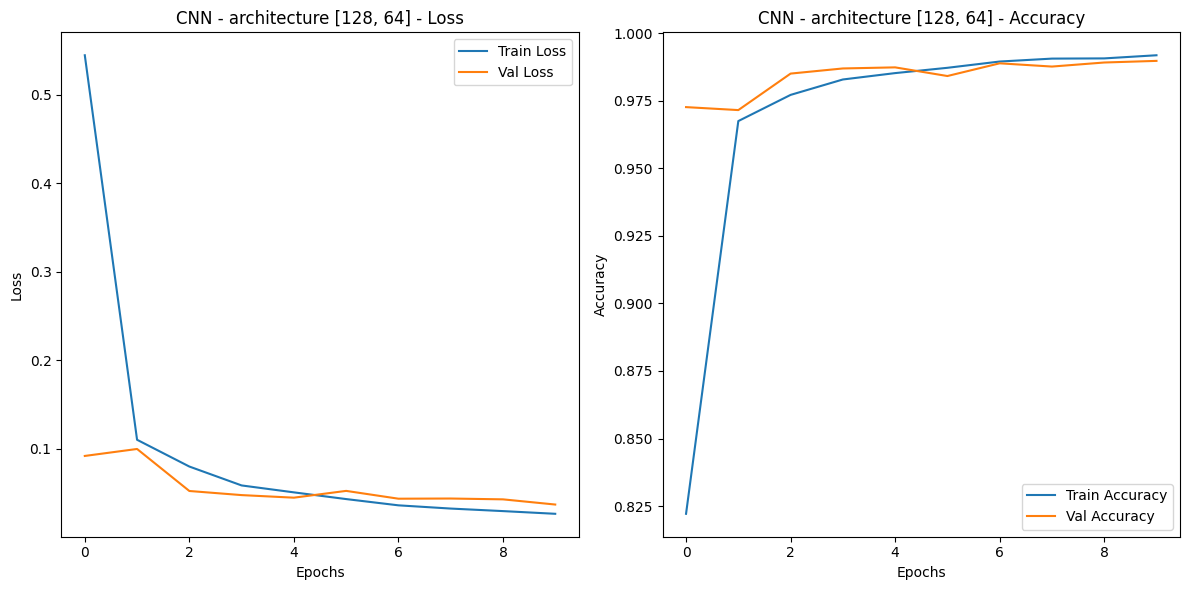


Testing architecture: [256, 128] for CNN
Epoch 1 - Training Loss: 0.4323, Validation Loss: 0.0974, Validation Accuracy: 0.9691
Epoch 2 - Training Loss: 0.0884, Validation Loss: 0.0622, Validation Accuracy: 0.9811
Epoch 3 - Training Loss: 0.0605, Validation Loss: 0.0523, Validation Accuracy: 0.9846
Epoch 4 - Training Loss: 0.0490, Validation Loss: 0.0567, Validation Accuracy: 0.9837
Epoch 5 - Training Loss: 0.0394, Validation Loss: 0.0438, Validation Accuracy: 0.9865
Epoch 6 - Training Loss: 0.0326, Validation Loss: 0.0400, Validation Accuracy: 0.9886
Epoch 7 - Training Loss: 0.0291, Validation Loss: 0.0397, Validation Accuracy: 0.9878
Epoch 8 - Training Loss: 0.0238, Validation Loss: 0.0373, Validation Accuracy: 0.9899
Epoch 9 - Training Loss: 0.0211, Validation Loss: 0.0345, Validation Accuracy: 0.9906
Epoch 10 - Training Loss: 0.0190, Validation Loss: 0.0381, Validation Accuracy: 0.9905


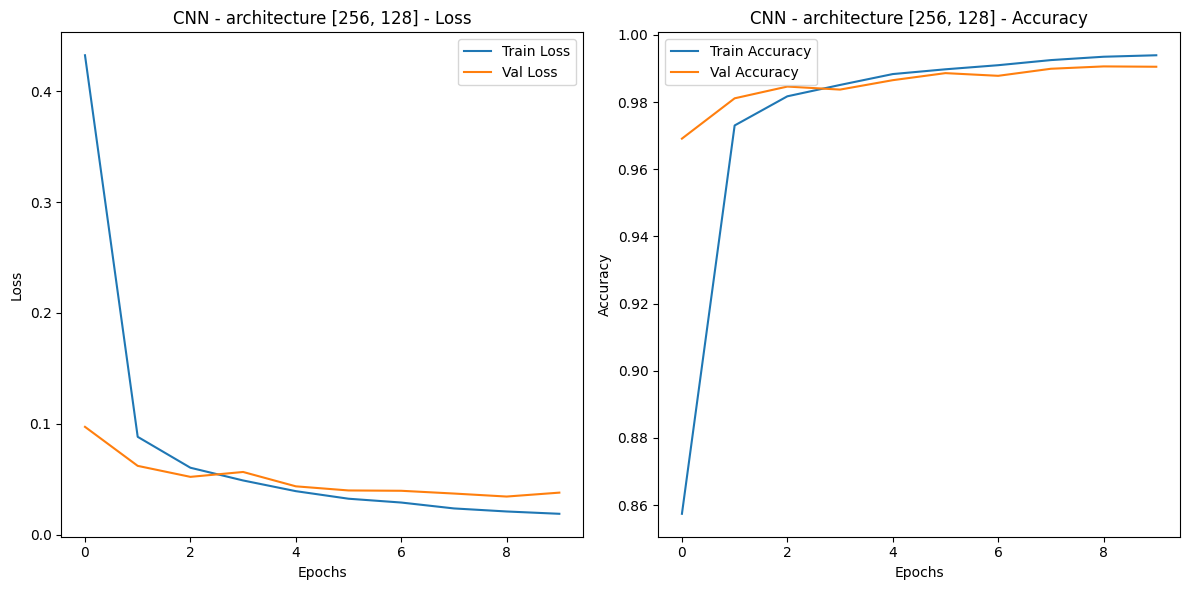


Testing architecture: [512, 256] for CNN
Epoch 1 - Training Loss: 0.3832, Validation Loss: 0.1058, Validation Accuracy: 0.9654
Epoch 2 - Training Loss: 0.0785, Validation Loss: 0.1331, Validation Accuracy: 0.9579
Epoch 3 - Training Loss: 0.0526, Validation Loss: 0.0476, Validation Accuracy: 0.9869
Epoch 4 - Training Loss: 0.0394, Validation Loss: 0.0416, Validation Accuracy: 0.9873
Epoch 5 - Training Loss: 0.0323, Validation Loss: 0.0400, Validation Accuracy: 0.9883
Epoch 6 - Training Loss: 0.0250, Validation Loss: 0.0402, Validation Accuracy: 0.9882
Epoch 7 - Training Loss: 0.0224, Validation Loss: 0.0371, Validation Accuracy: 0.9896
Epoch 8 - Training Loss: 0.0182, Validation Loss: 0.0398, Validation Accuracy: 0.9886
Epoch 9 - Training Loss: 0.0152, Validation Loss: 0.0362, Validation Accuracy: 0.9902
Epoch 10 - Training Loss: 0.0126, Validation Loss: 0.0419, Validation Accuracy: 0.9888


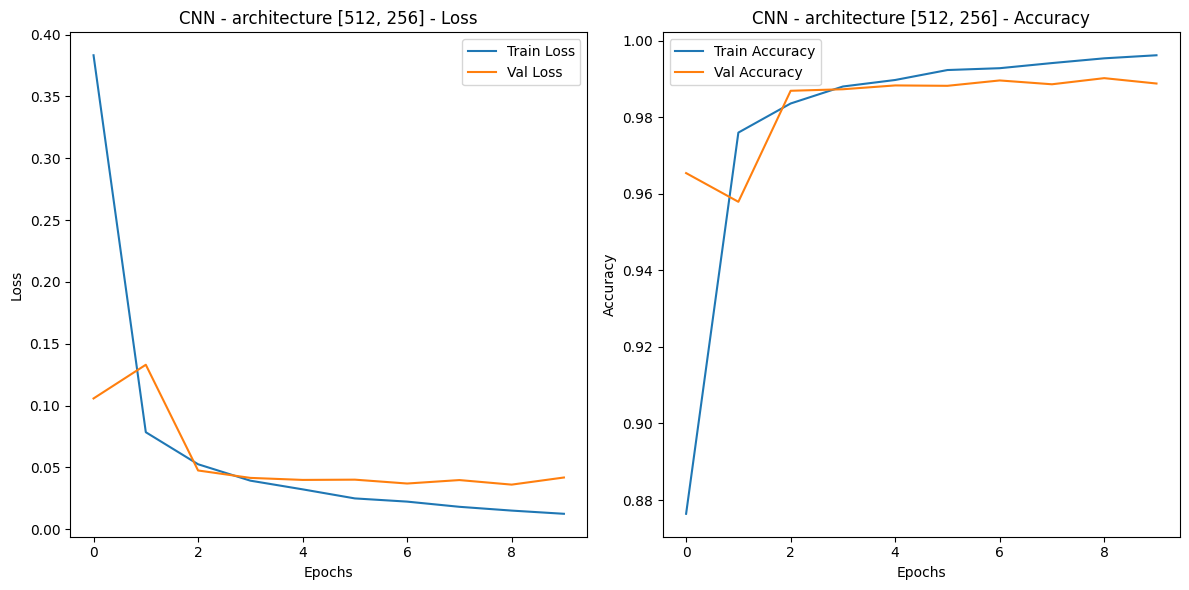


Testing architecture: [256] for CNN
Epoch 1 - Training Loss: 0.3810, Validation Loss: 0.1680, Validation Accuracy: 0.9483
Epoch 2 - Training Loss: 0.1409, Validation Loss: 0.1755, Validation Accuracy: 0.9466
Epoch 3 - Training Loss: 0.0944, Validation Loss: 0.0793, Validation Accuracy: 0.9760
Epoch 4 - Training Loss: 0.0738, Validation Loss: 0.1234, Validation Accuracy: 0.9616
Epoch 5 - Training Loss: 0.0591, Validation Loss: 0.0647, Validation Accuracy: 0.9816
Epoch 6 - Training Loss: 0.0492, Validation Loss: 0.1261, Validation Accuracy: 0.9584
Epoch 7 - Training Loss: 0.0420, Validation Loss: 0.0510, Validation Accuracy: 0.9844
Epoch 8 - Training Loss: 0.0346, Validation Loss: 0.0530, Validation Accuracy: 0.9857
Epoch 9 - Training Loss: 0.0306, Validation Loss: 0.0521, Validation Accuracy: 0.9850
Epoch 10 - Training Loss: 0.0269, Validation Loss: 0.0468, Validation Accuracy: 0.9859


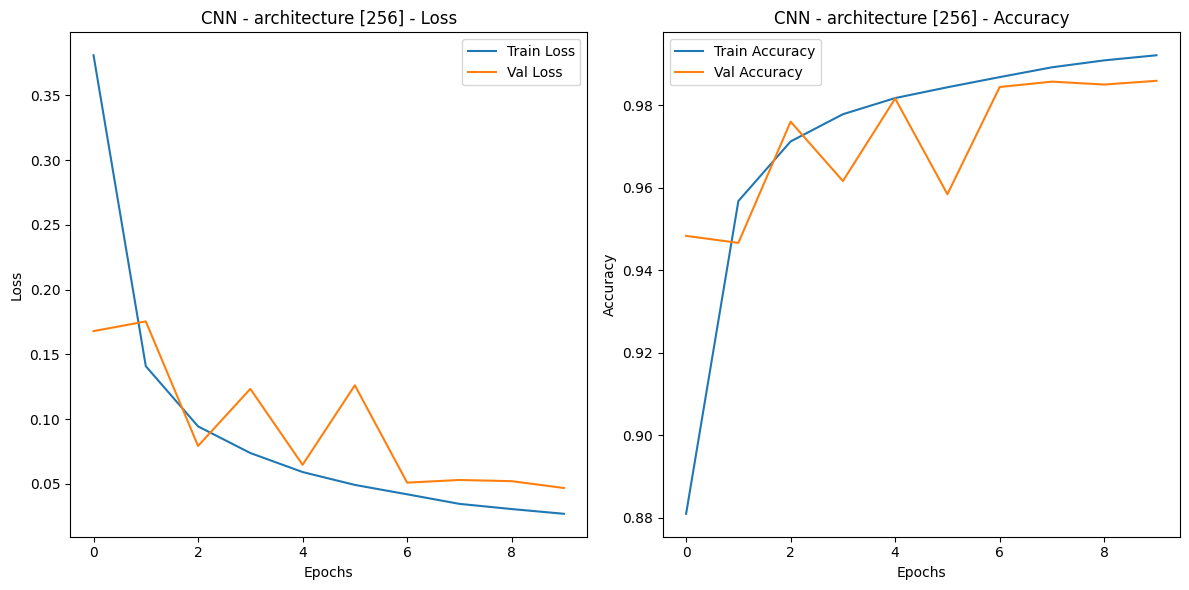


Testing architecture: [256, 128] for CNN
Epoch 1 - Training Loss: 0.4283, Validation Loss: 0.1598, Validation Accuracy: 0.9477
Epoch 2 - Training Loss: 0.0910, Validation Loss: 0.0640, Validation Accuracy: 0.9821
Epoch 3 - Training Loss: 0.0624, Validation Loss: 0.1054, Validation Accuracy: 0.9678
Epoch 4 - Training Loss: 0.0491, Validation Loss: 0.0422, Validation Accuracy: 0.9870
Epoch 5 - Training Loss: 0.0386, Validation Loss: 0.0410, Validation Accuracy: 0.9888
Epoch 6 - Training Loss: 0.0315, Validation Loss: 0.0384, Validation Accuracy: 0.9896
Epoch 7 - Training Loss: 0.0265, Validation Loss: 0.0364, Validation Accuracy: 0.9895
Epoch 8 - Training Loss: 0.0240, Validation Loss: 0.1143, Validation Accuracy: 0.9645
Epoch 9 - Training Loss: 0.0204, Validation Loss: 0.0387, Validation Accuracy: 0.9894
Epoch 10 - Training Loss: 0.0182, Validation Loss: 0.0360, Validation Accuracy: 0.9902


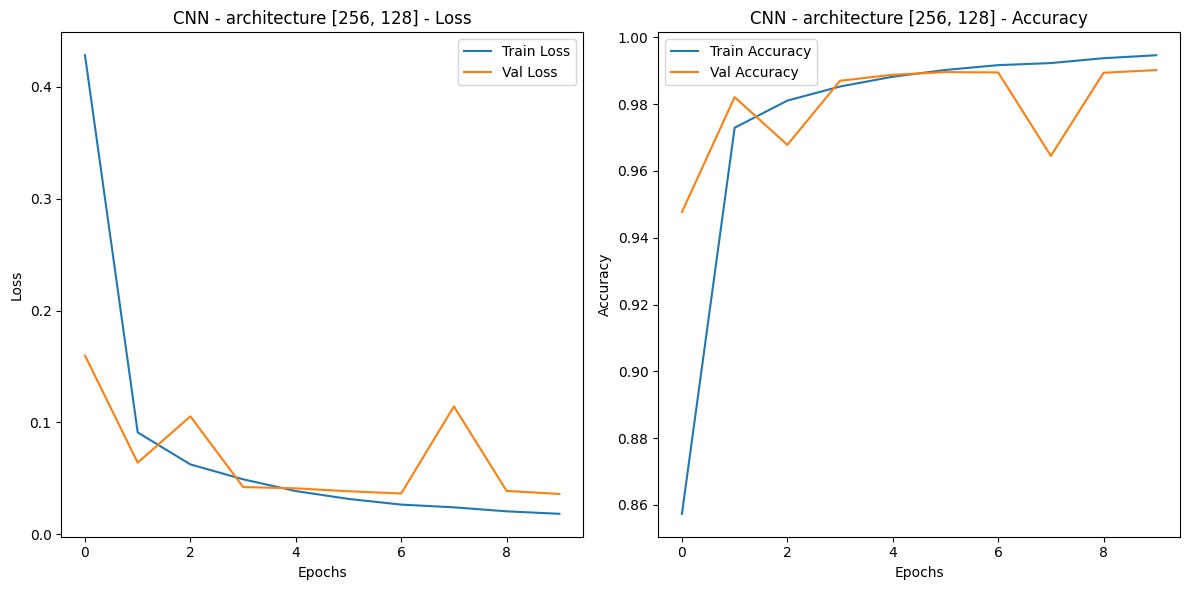


Testing architecture: [256, 128, 64] for CNN
Epoch 1 - Training Loss: 1.3687, Validation Loss: 0.2421, Validation Accuracy: 0.9275
Epoch 2 - Training Loss: 0.1432, Validation Loss: 0.0885, Validation Accuracy: 0.9749
Epoch 3 - Training Loss: 0.0877, Validation Loss: 0.0519, Validation Accuracy: 0.9833
Epoch 4 - Training Loss: 0.0612, Validation Loss: 0.0494, Validation Accuracy: 0.9865
Epoch 5 - Training Loss: 0.0476, Validation Loss: 0.0459, Validation Accuracy: 0.9879
Epoch 6 - Training Loss: 0.0401, Validation Loss: 0.0419, Validation Accuracy: 0.9892
Epoch 7 - Training Loss: 0.0353, Validation Loss: 0.0633, Validation Accuracy: 0.9825
Epoch 8 - Training Loss: 0.0268, Validation Loss: 0.0404, Validation Accuracy: 0.9903
Epoch 9 - Training Loss: 0.0268, Validation Loss: 0.0404, Validation Accuracy: 0.9906
Epoch 10 - Training Loss: 0.0222, Validation Loss: 0.0425, Validation Accuracy: 0.9905


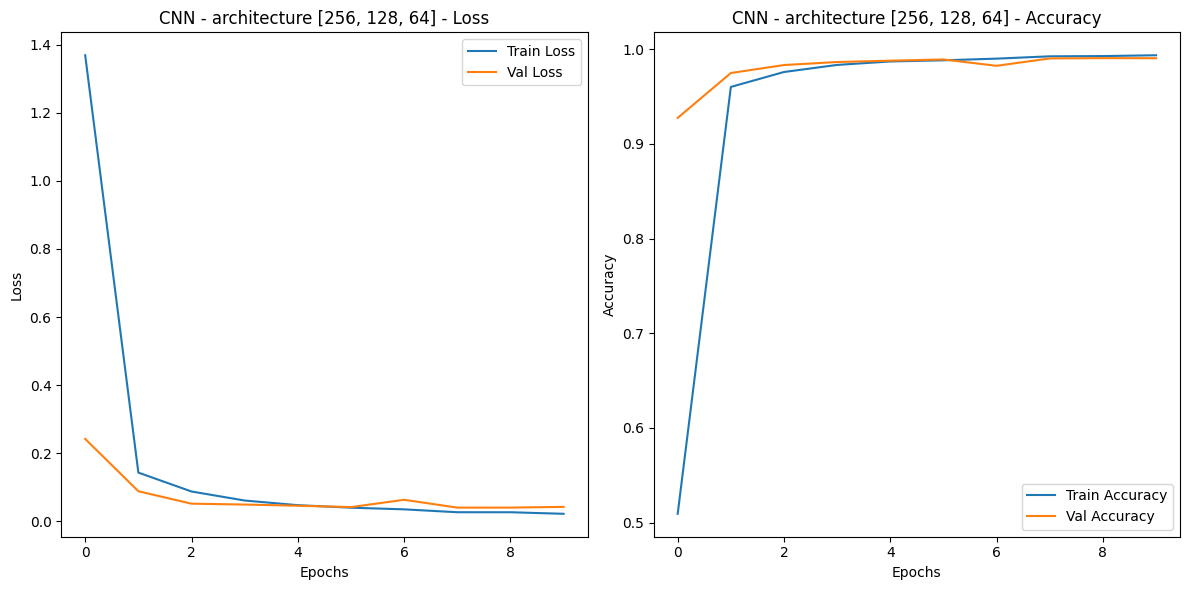


Testing architecture: [256, 128, 64, 32] for CNN
Epoch 1 - Training Loss: 2.3018, Validation Loss: 2.3012, Validation Accuracy: 0.1124
Epoch 2 - Training Loss: 2.2577, Validation Loss: 2.0554, Validation Accuracy: 0.2066
Epoch 3 - Training Loss: 1.1248, Validation Loss: 0.4543, Validation Accuracy: 0.8896
Epoch 4 - Training Loss: 0.2543, Validation Loss: 0.1697, Validation Accuracy: 0.9569
Epoch 5 - Training Loss: 0.1320, Validation Loss: 0.0746, Validation Accuracy: 0.9823
Epoch 6 - Training Loss: 0.0883, Validation Loss: 0.0678, Validation Accuracy: 0.9852
Epoch 7 - Training Loss: 0.0674, Validation Loss: 0.0639, Validation Accuracy: 0.9882
Epoch 8 - Training Loss: 0.0557, Validation Loss: 0.1244, Validation Accuracy: 0.9766
Epoch 9 - Training Loss: 0.0492, Validation Loss: 0.0683, Validation Accuracy: 0.9876
Epoch 10 - Training Loss: 0.0419, Validation Loss: 0.0601, Validation Accuracy: 0.9895


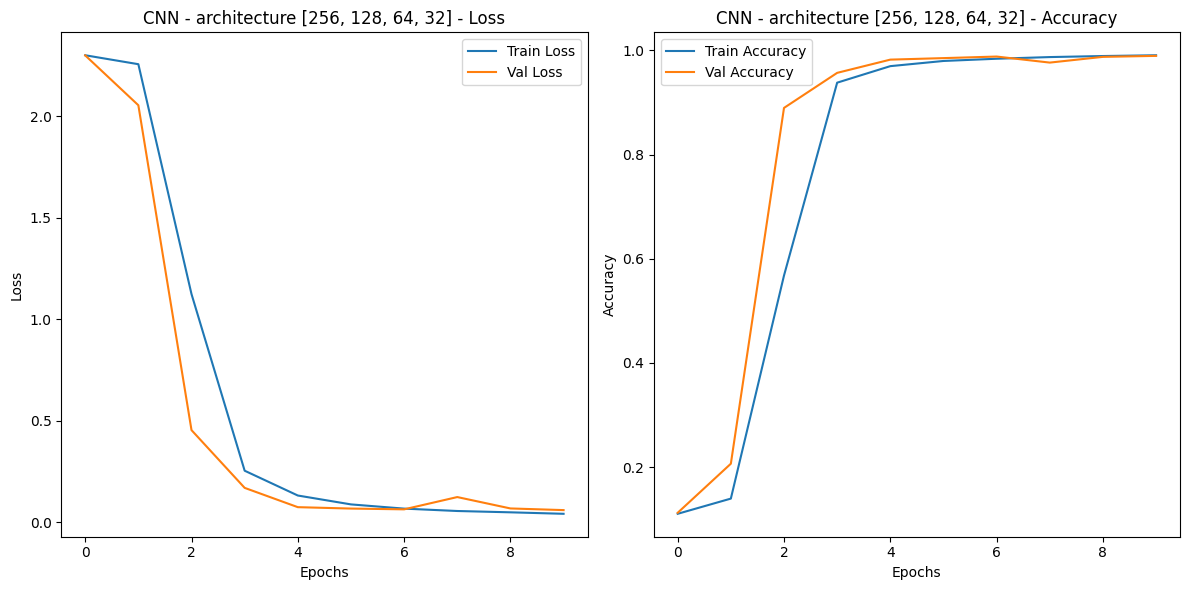

Best CNN architecture: [512, 256]


{'ANN': {'lr': 0.05,
  'batch_size': 64,
  'architecture': [512, 256],
  'val_loss': 0.0766954638095792},
 'CNN': {'lr': 0.1,
  'batch_size': 64,
  'architecture': [512, 256],
  'val_loss': 0.03275977981177235}}

In [63]:
tune_hyperparameter(layer_configs, "ANN", "architecture", best_hyperparams, criterion, epochs=20)
tune_hyperparameter(layer_configs, "CNN", "architecture", best_hyperparams, criterion, epochs=10)

# Final training with the best parameters for ANN

Epoch 1 - ANN Training Loss: 0.6958
Epoch 2 - ANN Training Loss: 0.2765
Epoch 3 - ANN Training Loss: 0.2090
Epoch 4 - ANN Training Loss: 0.1641
Epoch 5 - ANN Training Loss: 0.1355
Epoch 6 - ANN Training Loss: 0.1135
Epoch 7 - ANN Training Loss: 0.0971
Epoch 8 - ANN Training Loss: 0.0833
Epoch 9 - ANN Training Loss: 0.0728
Epoch 10 - ANN Training Loss: 0.0642
Epoch 11 - ANN Training Loss: 0.0562
Epoch 12 - ANN Training Loss: 0.0499
Epoch 13 - ANN Training Loss: 0.0443
Epoch 14 - ANN Training Loss: 0.0387
Epoch 15 - ANN Training Loss: 0.0342
Epoch 16 - ANN Training Loss: 0.0298
Epoch 17 - ANN Training Loss: 0.0272
Epoch 18 - ANN Training Loss: 0.0238
Epoch 19 - ANN Training Loss: 0.0216
Epoch 20 - ANN Training Loss: 0.0187
Epoch 21 - ANN Training Loss: 0.0163
Epoch 22 - ANN Training Loss: 0.0144
Epoch 23 - ANN Training Loss: 0.0131
Epoch 24 - ANN Training Loss: 0.0114
Epoch 25 - ANN Training Loss: 0.0102
Epoch 26 - ANN Training Loss: 0.0093
Epoch 27 - ANN Training Loss: 0.0082
Epoch 28 -

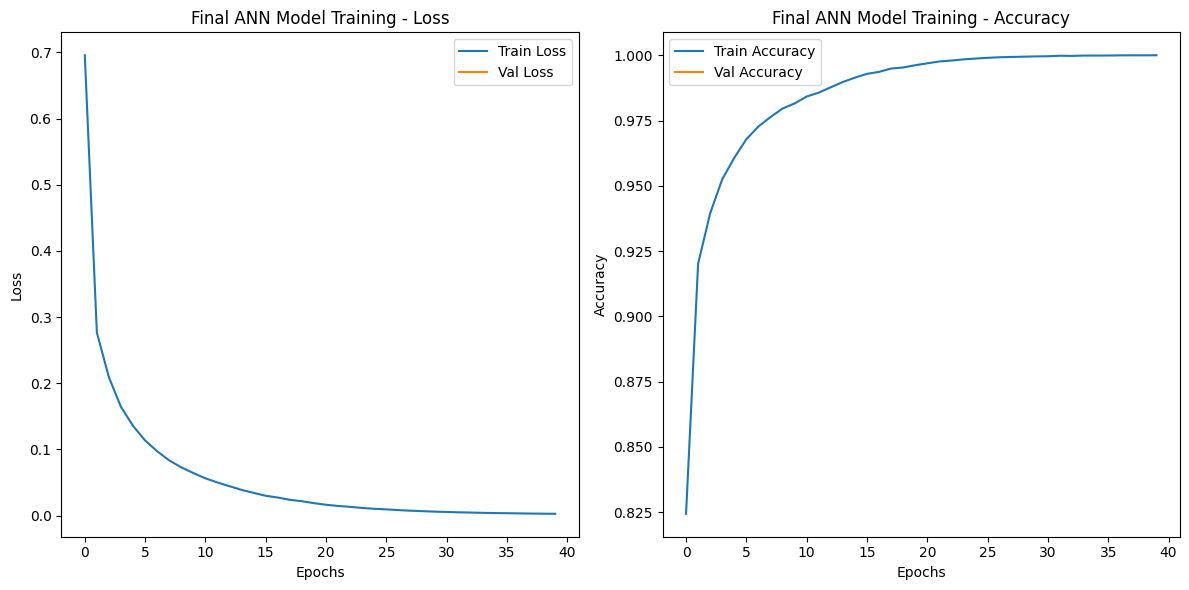

In [64]:
final_ann_model = NeuralNetwork(best_hyperparams['ANN']['architecture'])
optimizer = optim.SGD(final_ann_model.parameters(), lr=best_hyperparams['ANN']['lr'])
train_loader = DataLoader(train_dataset_ann, batch_size=best_hyperparams['ANN']['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset_ann, batch_size=best_hyperparams['ANN']['batch_size'], shuffle=False)
final_ann_model = final_ann_model.to(device)

train_losses, train_accuracies = [], []
for epoch in range(40):
    final_ann_model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = final_ann_model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(output, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)
    print(f"Epoch {epoch + 1} - ANN Training Loss: {train_losses[-1]:.4f}")

plot_metrics(train_losses, [], train_accuracies, [], "Final ANN Model Training")

# Evaluate ANN on test data


ANN Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



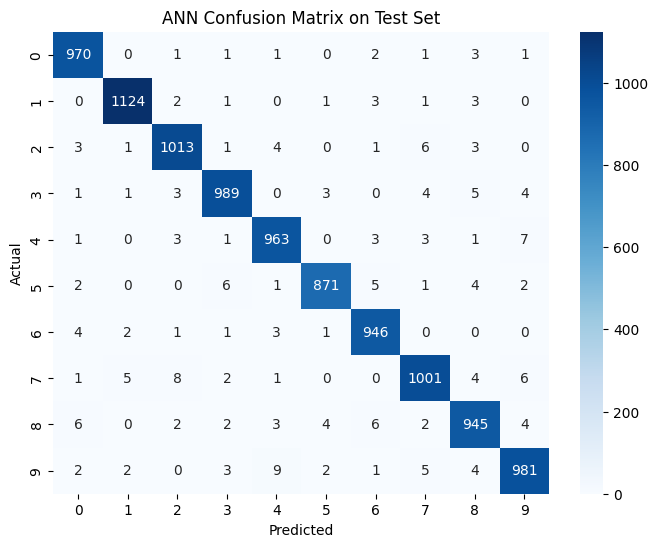

In [65]:
y_true, y_pred = [], []
final_ann_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = final_ann_model(images)
        _, preds = torch.max(output, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print("\nANN Classification Report on Test Set:")
print(classification_report(y_true, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ANN Confusion Matrix on Test Set')
plt.show()

# Final training with the best parameters for CNN

Epoch 1 - CNN Training Loss: 0.3615
Epoch 2 - CNN Training Loss: 0.0791
Epoch 3 - CNN Training Loss: 0.0546
Epoch 4 - CNN Training Loss: 0.0422
Epoch 5 - CNN Training Loss: 0.0330
Epoch 6 - CNN Training Loss: 0.0275
Epoch 7 - CNN Training Loss: 0.0225
Epoch 8 - CNN Training Loss: 0.0196
Epoch 9 - CNN Training Loss: 0.0163
Epoch 10 - CNN Training Loss: 0.0147
Epoch 11 - CNN Training Loss: 0.0110
Epoch 12 - CNN Training Loss: 0.0102
Epoch 13 - CNN Training Loss: 0.0087
Epoch 14 - CNN Training Loss: 0.0080
Epoch 15 - CNN Training Loss: 0.0069
Epoch 16 - CNN Training Loss: 0.0065
Epoch 17 - CNN Training Loss: 0.0062
Epoch 18 - CNN Training Loss: 0.0042
Epoch 19 - CNN Training Loss: 0.0043
Epoch 20 - CNN Training Loss: 0.0034
Epoch 21 - CNN Training Loss: 0.0035
Epoch 22 - CNN Training Loss: 0.0030
Epoch 23 - CNN Training Loss: 0.0030
Epoch 24 - CNN Training Loss: 0.0038
Epoch 25 - CNN Training Loss: 0.0032


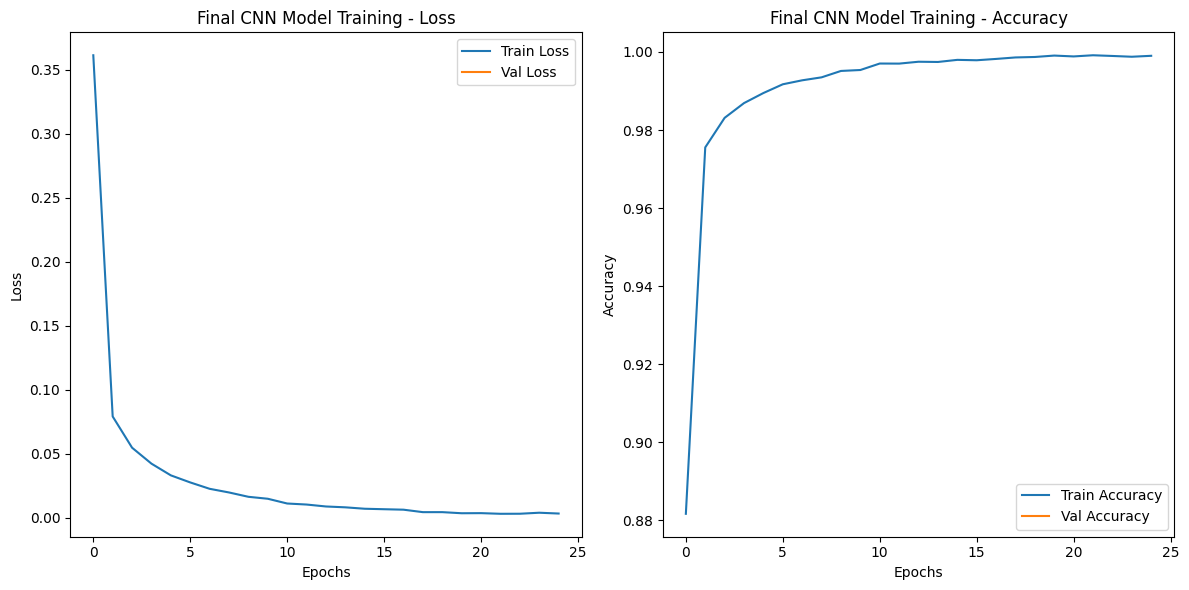

In [66]:
final_cnn_model = CNNModel(best_hyperparams['ANN']['architecture'], dropout_rate=0.25)
optimizer = optim.SGD(final_cnn_model.parameters(), lr=best_hyperparams['CNN']['lr'])
train_loader = DataLoader(train_dataset_cnn, batch_size=best_hyperparams['CNN']['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset_cnn, batch_size=best_hyperparams['CNN']['batch_size'], shuffle=False)
final_cnn_model = final_cnn_model.to(device)

train_losses, train_accuracies = [], []
for epoch in range(25):
    final_cnn_model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = final_cnn_model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(output, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)
    print(f"Epoch {epoch + 1} - CNN Training Loss: {train_losses[-1]:.4f}")

plot_metrics(train_losses, [], train_accuracies, [], "Final CNN Model Training")

# Evaluate CNN on test data


CNN Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      1.00      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



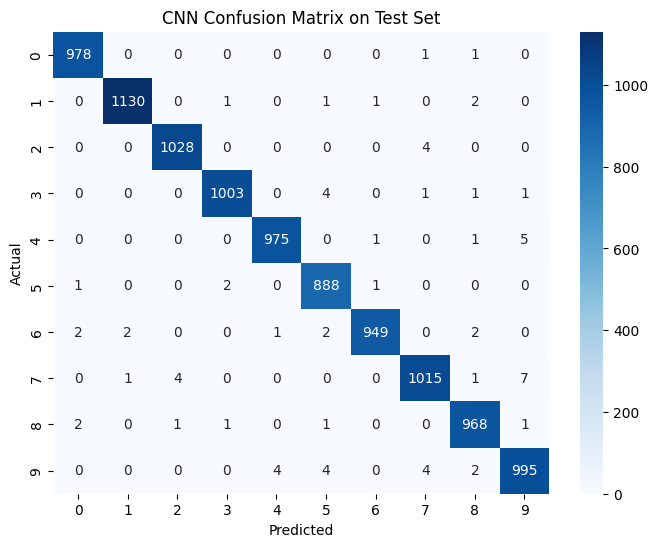

In [68]:
y_true, y_pred = [], []
final_cnn_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = final_cnn_model(images)
        _, preds = torch.max(output, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print("\nCNN Classification Report on Test Set:")
print(classification_report(y_true, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN Confusion Matrix on Test Set')
plt.show()